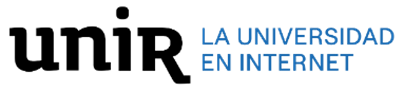
--------
#**Sistema de Recomendación para la toma de Decisiones Financieras en la Administración de Condominios**
#**Master Universitario en Inteligencia Artificial**
###**Autor**
1. Nombre: Luís Humberto
1. Apellido: Paz y Miño Espinosa
1. Correo:
--------
###**V1.0**
--------
###**2025**

##1. Importación de Paquetes Necesarios para procesos ETL sobre archivos extraídos:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             #visualización
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
#!pip install skforecast
#!pip install surprise
from pyspark.sql import SparkSession
import ipywidgets as widgets
from IPython.display import display

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
#establecer como True en caso de querer usar google drive
useGoogleDrive = True
#puede ser , o ;
delimiter = ","
#ingresea aquí la dirección de la carpeta que contiene los archivos .csv
rootDir = '/content/drive/MyDrive/DATA-20250211T014001Z-001/DATA/V2/'

## 2. Carga de repositorio Google Drive

In [2]:
if useGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive/')

Mounted at /content/drive/


## 3. Lectura del Dataset Condominios extraido de Sistema de Información Financiera para la administración de Condominios:
El dataset, es cargado preliminarmente en el repositorio Google Drive y este es obtenido del software de gestión de cuentas de condominios.

In [3]:
df = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'condominios.csv')
df.createOrReplaceTempView("Condominios")
df.show()

+-------------+--------------+----------+-----------+------+-------------+--------+--------+--------------------+------------------+--------------------+
|id_condominio|tipocondominio|codlatitud|codlongitud|ciudad|totalunidades|mincuota|maxcuota|            avgcuota|totalcuota_mensual|               tipos|
+-------------+--------------+----------+-----------+------+-------------+--------+--------+--------------------+------------------+--------------------+
|           15|  Urbanización|    -0.227|    -78.444| Quito|          186|    0.00|  165.00| 35.5645161290322581|           6615.00| Lote: 30| Casa: 156|
|           42|  Urbanización|     -0.09|    -80.187|  Jama|          115|    0.00|  228.62|100.3231304347826087|          11537.16|           Lote: 115|
|           47|      Edificio| -0.169713| -78.476977| Quito|           72|   41.46|  151.96| 73.6283333333333333|           5301.24|    Departamento: 72|
|           48|      Edificio|    -0.178|    -78.481| Quito|           45|  

## 4. Agrupación del Dataset por tipo de condomio:
En esta partición, se observa un total de 9 tipos de condominios, los cuales se agrupan en unidades y ubicaciones ciudades de Ecuador

In [4]:
tipos_condominios = df.groupBy("tipocondominio").count()
tipos_condominios.show()

+--------------------+-----+
|      tipocondominio|count|
+--------------------+-----+
|    Centro Comercial|    6|
|        Urbanización|  130|
|              Cowork|    2|
|          Condominio|   99|
|            Conjunto|  374|
|            Edificio|  817|
|          Lotización|    2|
|Consultorios Médicos|    3|
|              Cuenta|    5|
+--------------------+-----+



## 5. Evaluación de densidad de ciudades según tipo de condominio inpeccionado:


Dropdown(description='Selecciona:', options=('Centro Comercial', 'Urbanización', 'Cowork', 'Condominio', 'Conj…

Seleccionaste: Condominio


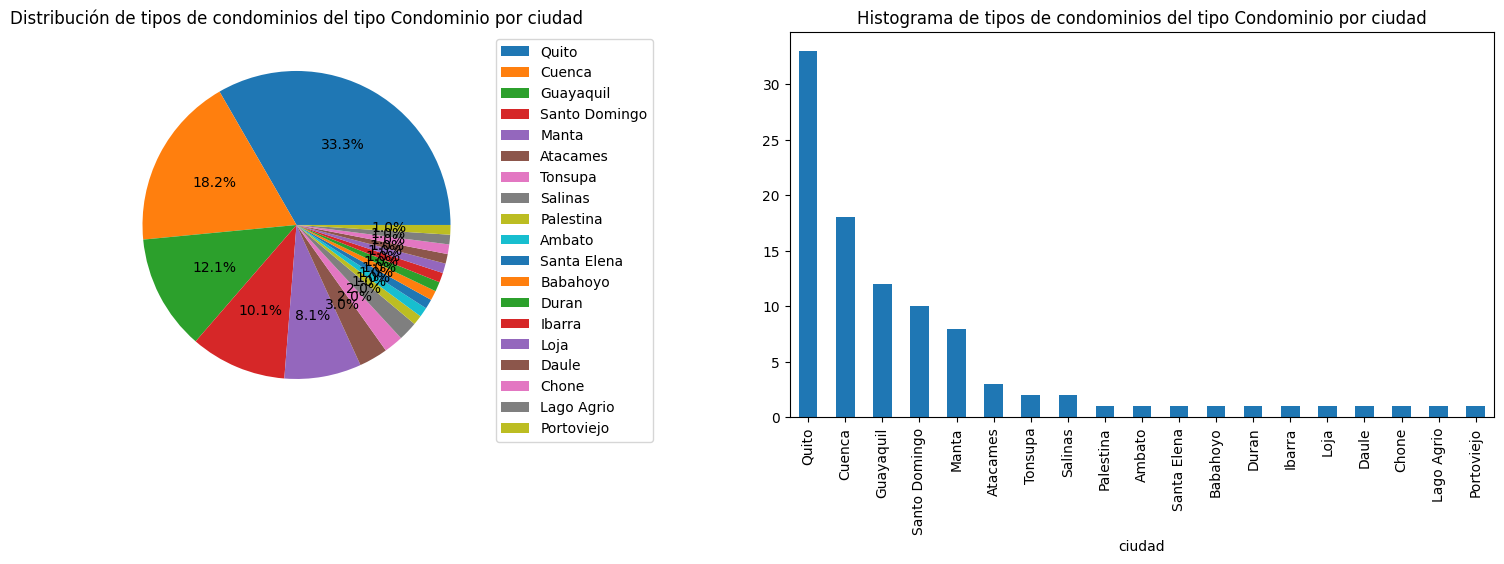

In [5]:
#sqlDF = spark.sql("SELECT tipocondominio FROM Condominios")
#sqlDFpandas=sqlDF.toPandas()

opciones = [row["tipocondominio"] for row in tipos_condominios.select("tipocondominio").collect()]
menu_desplegable = widgets.Dropdown(
    options=opciones,
    value=opciones[0],  # Valor inicial seleccionado
    description='Selecciona:',  # Etiqueta del menú
    disabled=False  # Si está deshabilitado o no
)

# 2. Función que se ejecuta cuando se selecciona una opción
def on_change(change):
    print(f"Seleccionaste: {change['new']}")
    tcondominio = change['new']
    sqlDF = spark.sql(f"SELECT ciudad,tipocondominio FROM Condominios WHERE tipocondominio=='{tcondominio}'")

    sqlDFpandas=sqlDF.toPandas()
    fig, (ax1,ax2) = plt.subplots(1,2)
    graf=sqlDFpandas["ciudad"].value_counts()
    labels=graf.keys() #obtenemos los labels
    ax1.pie(graf,labeldistance=0.9,autopct='%0.1f%%') #graficamos
    #ax1.pie(graf, labels=graf.keys())
    ax1.legend(labels, bbox_to_anchor =(1, 1)) #especificamos la leyenda
    ax1.set_title("Distribución de tipos de condominios del tipo "+tcondominio+" por ciudad")
    ax1.plot()
    sqlDFpandas["ciudad"].value_counts().plot(kind='bar', figsize=(20,5))
    ax2.set_title("Histograma de tipos de condominios del tipo "+tcondominio+" por ciudad")
    ax2.plot()

# 3. Vincular la función al evento 'value' del menú desplegable
menu_desplegable.observe(on_change, names='value')
display(menu_desplegable)



###Resultados de la evaluación de la distribución de los diferentes tipos de condominios en las ciudades:


1.    **Tipo Centro Comercial:** En **Quito** se encuentran el 50.0% de las unidades, mientras que en Guayaquil, Daule y Duran, se ubican 16.7%, a partes iguales, observados en el diagrama circular, mientras que en el histograma el ancho de clases para **Quito** se ubica en 3 elementos y para Guayaquil. Daule y Duran corresponde a 1 elemento respectivamente.

2.    **Tipo Urbanización:**en este caso **Quito** vuelve a concentrar el mayor porcentaje, correspondiente a 59.2%, observado en el diagrama circular, mientras que la sumatoria de los porcentajes de las otras ciudades observada corresponden al 40.8% y de este porcentaje, Guayaquil ocupa 6.2%, después de Samborondon con 6.9%. Este comportamiento incluso en el histograma es mucho más evidente que la proporción de condominios tipo Urbanización en **Quito**, teniendo un ancho de clase de alrededor de 75 elementos.

3.    **Tipo Cowork:**para este caso todos los elementos, se ubican en **Quito**, en el diagrama circular ocupa el 100% y en el histograma el ancho de clase es de 2 elementos, coincidiendo con el número de elementos registrados al principio.

4.    **Tipo Condominio:** **Quito**, al igual que en los casos anteriores aglomera el mayor porcentaje, correspondiente a 33.3% en el gráfico circular, luego le siguen Cuenca con 18.2%, Guayaquil con 12.1%, Santo Domingo con 10.1% y Manta con 8.1%, siendo los porcentajes más significativos de la distribución. En el histograma **Quito** cuenta con aproximadamente 35 elementos de clase, Cuenca 25, Guayaquil 15, Santo Domingo 10 y Manta 8, mientras que el resto de las ciudades se encuentran por debajo de 5.

5.    **Tipo Conjunto:** para este caso **Quito** concentra el 89.8% del diagrma circular, mientras que en el histograma tiene un poco más de 325 elementos de clase, lo que conduce a que efectivamente **Quito** es quien concentra casi la totalidad de los elementos de este tipo ubicados en el data set.

6.    **Tipo Edificio:**En este caso, sucede algo similar al caso anterior, difieren en el porcentaje porque **Quito** concentra el 87.5%, pero la concentración dentro del diagrma circular es similar, mientras que en el histograma se observan alrededor de 720 o 730 elementos de clase.

7.    **Tipo Lotización:**en este caso **Quito** tiene el 50% y Pedro Moncayo el otro 50% dentro del diagrama circular, mientras que en el Histograma se observa 1 elemento para cada clase, correspondiente a la cantidad que se observa en la consulta por tipo de condominio.
8.    **Tipo Consultorios Médicos:** el porcentaje para **Quito** es de 66.7%, mientras que Samborondon 33.3% dentro del diagrama circular, en el Histograma **Quito** tiene 2 elementos de clase, Samborondon 1.
9.    **Tipo Cuenta:**en este caso **Quito** posee el 80.0% del diagrama circular y Guayaquil el 20.0%, lo que corresponde en el Histograma a 4 elementos de clase para **Quito** y 1 para Guayaquil.

Esta primera observación de conjuntos, perfila a la ciudad de Quito como la que concentra la mayor cantidad de condominios del dataset, se procede entonces a refinar aún más el perfil para la posterior evaluación de la data de ingresos y egresos asociadas a los movimientos financieros.

## 6. Obtención de id's de condominios de interés:
En este paso se obtiene la vista temporal de los datos de condominios, con el objeto de extraer aquellos ids asociados al tipo de condominio a Evaluar en la ciudad de Quito, según la distribución de data observada previamente.

In [6]:
df2 = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'condominios.csv')
df2.createOrReplaceTempView("datos_condominios")

Se crea una nueva instancia de Dataframe, para ahora hacer la búsqueda refinada por tipo de condomio y ciudad="Quito", con el objetivo de hacer luego la consulta cruzada con id_condominio a los archivos de finanzas.

In [7]:

tcondominio = input("Seleccione un tipo de condominio:")
sqlDF2 = spark.sql(f"SELECT id_condominio,ciudad, totalunidades, tipos, tipocondominio FROM datos_condominios WHERE ciudad='Quito' and tipocondominio='{tcondominio}'")
sqlDF2.show()
sqlDF2pandas=sqlDF2.toPandas()
X=pd.DataFrame({"id_condominio":sqlDF2pandas["id_condominio"]})
print("Total de Filas: "+str(len(X)))
lindex=[]
for i in range (0, len(X)):
  lindex.append(i)
X.index=lindex
print(X)



Seleccione un tipo de condominio:Condominio
+-------------+------+-------------+--------------------+--------------+
|id_condominio|ciudad|totalunidades|               tipos|tipocondominio|
+-------------+------+-------------+--------------------+--------------+
|         1073| Quito|           21|            Casa: 21|    Condominio|
|         1111| Quito|           68|    Departamento: 68|    Condominio|
|         1120| Quito|           12|            Casa: 12|    Condominio|
|         1432| Quito|          104|           Casa: 104|    Condominio|
|         1476| Quito|           61|Departamento: 60|...|    Condominio|
|         1495| Quito|           53|Parqueadero: 9| D...|    Condominio|
|         1518| Quito|           20|            Casa: 20|    Condominio|
|         1527| Quito|           30|     Apartamento: 30|    Condominio|
|         1541| Quito|           20|            Lote: 20|    Condominio|
|         1552| Quito|           42|          Bodega: 42|    Condominio|
|      

##7. Lectura del Dataset Cuentas por Pagar extraido de Sistema de Información Financiera para la administración de Condominios:
El dataset, es cargado totalmente en el repositorio Google Drive y este es obtenido del software de gestión contable de condominios, al leerlo se cargan la totalidad de los datos obtnidos de todos los condominios, se requiere realizar un filtrado por id de condominio y ciudad de ubicación, el cual se realizará con los resultados obtenidos del paso consulta de id's

In [8]:
df3 = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXpagar_egresos.csv')
df3.show()

+-------------+------+---------------+--------------------+--------------------+----------+----------------+-------+-----+----------+----------+---------------------+
|id_condominio|id_cxp|      categoria|     cuenta_contable|             detalle|     fecha|fechavencimiento|  valor|saldo|fecha_pago|valor_pago|diff_fecha_menos_pago|
+-------------+------+---------------+--------------------+--------------------+----------+----------------+-------+-----+----------+----------+---------------------+
|          388| 60489|Egresos Comunes|    Consumo Teléfono|Pago factura cons...|2019-01-01|      2019-01-30|  16.80| 0.00|2019-01-18|     16.80|                   17|
|          457| 60467|Egresos Comunes|Servicios de Guar...|   Alianza Monitoreo|2019-01-01|      2019-01-18| 280.00| 0.00|2019-01-18|    280.00|                   17|
|          457| 60466|Egresos Comunes|Mantenimiento de ...|Mantenimiento asc...|2019-01-01|      2019-01-18| 202.05| 0.00|2019-01-17|    202.05|                   16

## 8.  Filtrado del dataset al tipo de condominio a Evaluar:
En este paso, se disgrega la consulta al tipo de condominio a evaluar por id's asociado a este tipo y ubicación.

In [9]:
df3.createOrReplaceTempView("cuentasXpagar")
cuentaspfin=pd.DataFrame()
# Obtener todos los id_condominio como una lista desde X
id_condominios = tuple(X['id_condominio'].astype(str).tolist())  # Convertir a string y a tupla para SQL

# Construir una sola consulta SQL con WHERE IN
consulta = f"""
    SELECT id_condominio, categoria, cuenta_contable, fecha, fechavencimiento,
           valor, saldo, fecha_pago, valor_pago
    FROM cuentasXpagar
    WHERE id_condominio IN {id_condominios}
"""

sqlDF3 = spark.sql(consulta)

# Convertir directamente a Pandas
cuentaspfin = sqlDF3.toPandas()

# Imprimir resultados
print(cuentaspfin)
print("Total de Filas: " + str(len(cuentaspfin)))


     id_condominio        categoria                   cuenta_contable  \
0             1073  Egresos Comunes           Servicios de Guardianía   
1             1073  Egresos Comunes                      Agua potable   
2             1073  Egresos Comunes  Plan pagos Ferretería La Granja    
3             1120  Egresos Comunes           Servicios de Guardianía   
4             1073  Egresos Comunes  Plan pagos Ferretería La Granja    
...            ...              ...                               ...   
7526          1073  Egresos Comunes                    Administración   
7527          1073  Egresos Comunes         Mantenimiento de Jardines   
7528          1073  Egresos Comunes           Servicios de Guardianía   
7529          1073  Egresos Comunes           Servicios de Guardianía   
7530          2334  Egresos Comunes                  Sueldos Personal   

           fecha fechavencimiento    valor   saldo  fecha_pago valor_pago  
0     2021-01-14       2021-01-31  2080.00    0

## 9. Exploración de las Cuentas por Pagar: categorías y denominaciones a lo largo de los años 2019 al 2024 del tipo de condominio seleccionado
En este caso, se hace una exploración de las cuentas creadas en el tipo de condominio seleccionado, durante el período de años desde el 2019 al 2024, fechas de extracción de registros de la data.

Seleccione un año (2019, 2020, 2021, 2022, 2023): 2023
Total de Filas: 498965
Datos reducidos a una muestra de 1000 filas para visualización


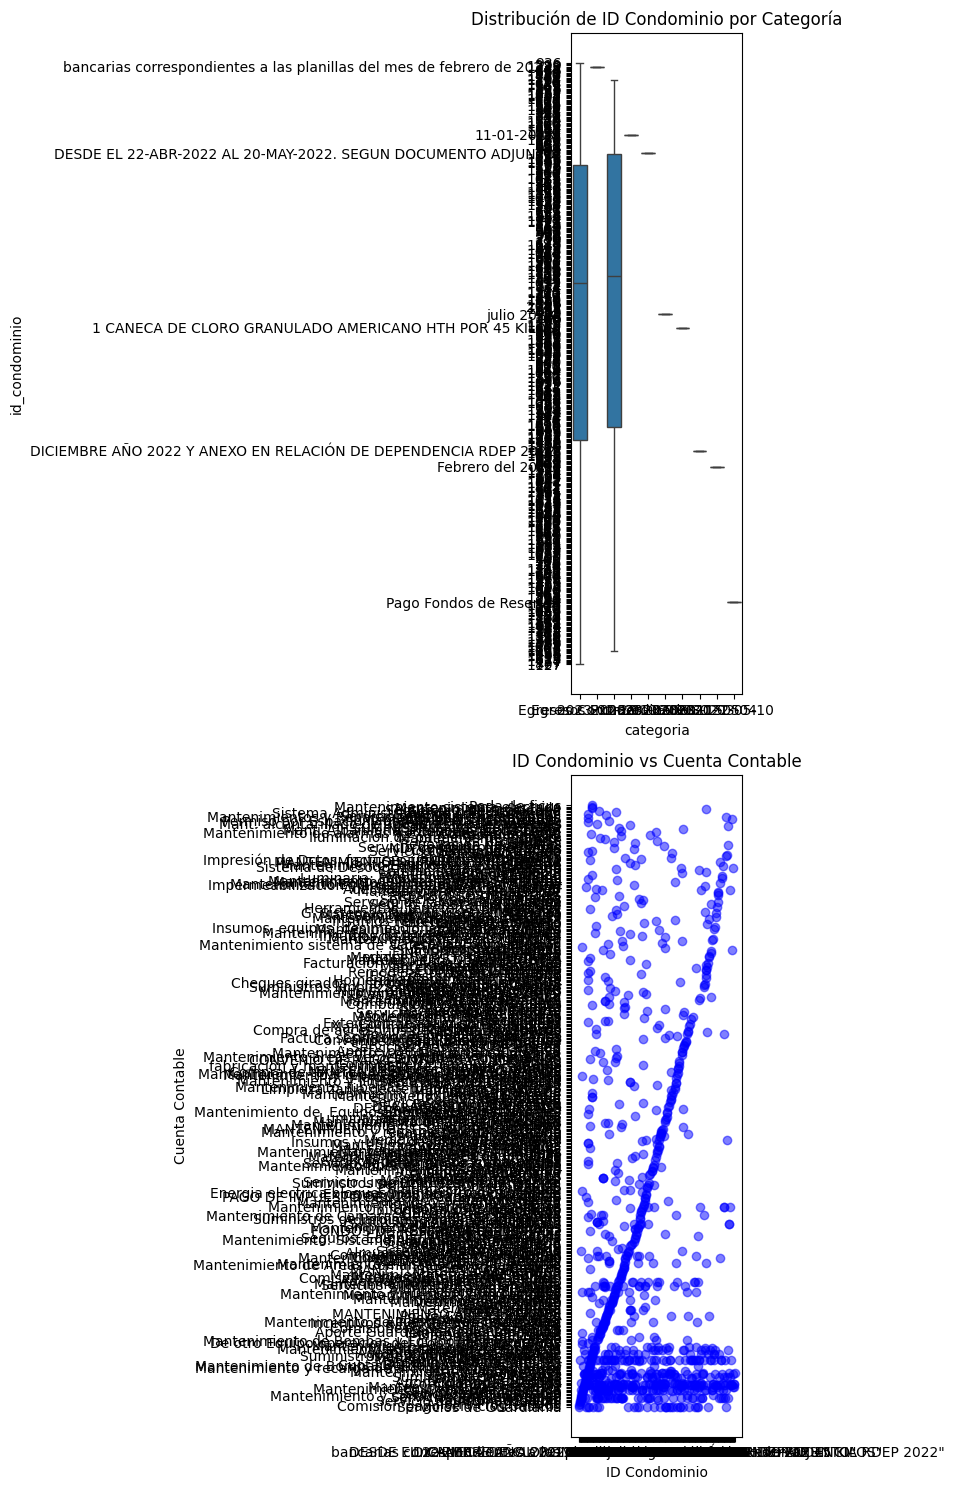

In [10]:
from pyspark.sql.functions import col

opciones_ano = [str(ano) for ano in np.arange(2019, 2024)]
anoex = input(f"Seleccione un año ({', '.join(opciones_ano)}): ")

# Asumiendo que cuentaspfin originalmente viene de un DataFrame de Spark (df3)
# Filtrar en Spark antes de convertir a Pandas
spark_df = df3.filter((col("fecha") >= "2019-01-01") & (col("fecha") <= f"{anoex}-12-31"))
dataex = spark_df.toPandas()  # Convertir solo los datos filtrados
print("Total de Filas: " + str(len(dataex)))

# Si los datos siguen siendo demasiados, tomar una muestra
if len(dataex) > 1000:  # Ajusta este límite según tus necesidades
    dataex = dataex.sample(n=1000, random_state=42)  # Muestreo aleatorio
    print(f"Datos reducidos a una muestra de 1000 filas para visualización")

# Crear los gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 15))

# Boxplot sin swarmplot para categorías (más rápido y claro con muchos datos)
sns.boxplot(x="categoria", y="id_condominio", data=dataex, ax=ax1)
ax1.set_title("Distribución de ID Condominio por Categoría")

# Scatter plot en el segundo eje
ax2.scatter(dataex["id_condominio"], dataex["cuenta_contable"], alpha=0.5, color="blue")
ax2.set_xlabel("ID Condominio")
ax2.set_ylabel("Cuenta Contable")
ax2.set_title("ID Condominio vs Cuenta Contable")

plt.tight_layout()
plt.show()

## 10. Saldos de las Cuentas por Pagar:
En este apartado se verfica el saldo pendiente de las cuentas por pagar en el período seleccionado

Filas originales: 1000, Filas después de limpieza: 992


<ipython-input-11-1a86941058b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataex_clean["saldo"] = pd.to_numeric(dataex_clean["saldo"], errors="coerce")
<ipython-input-11-1a86941058b2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataex_clean["cuenta_contable"] = pd.to_numeric(dataex_clean["cuenta_contable"], errors="coerce")


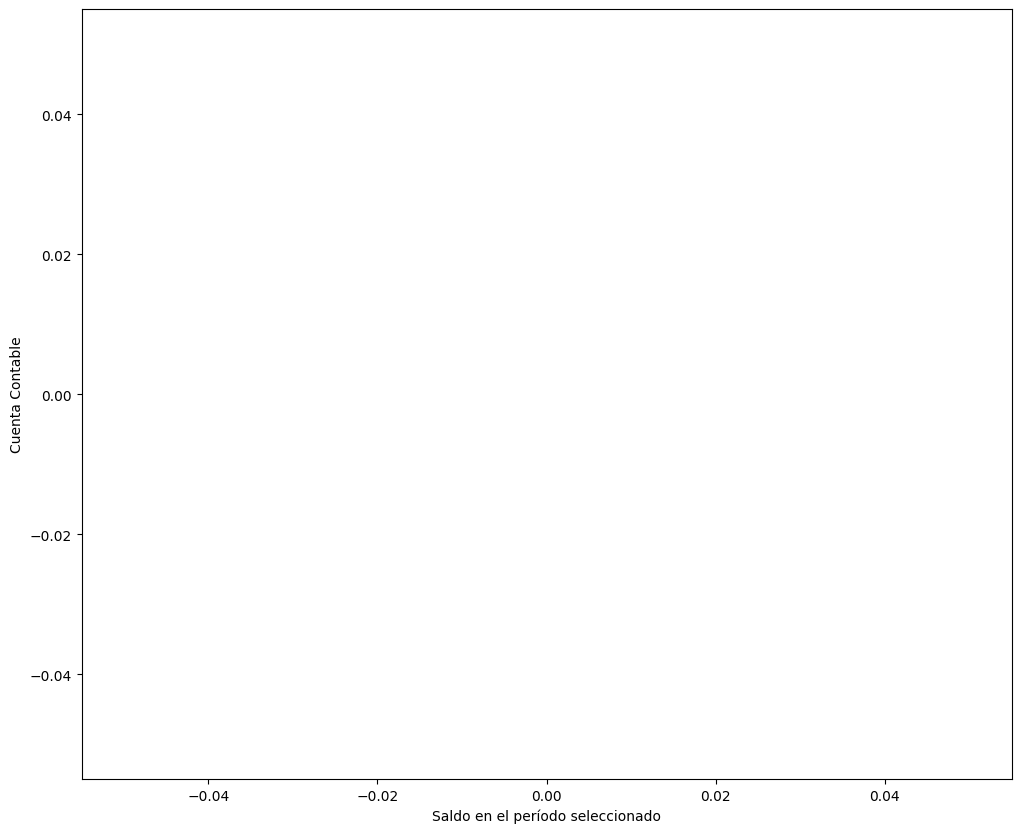

In [11]:
# Crear la figura y el eje
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Limpiar los datos: eliminar filas con None/NaN en las columnas relevantes
dataex_clean = dataex.dropna(subset=["saldo", "cuenta_contable"])

# Asegurarse de que las columnas sean numéricas
dataex_clean["saldo"] = pd.to_numeric(dataex_clean["saldo"], errors="coerce")
dataex_clean["cuenta_contable"] = pd.to_numeric(dataex_clean["cuenta_contable"], errors="coerce")

# Verificar cuántas filas quedan después de la limpieza
print(f"Filas originales: {len(dataex)}, Filas después de limpieza: {len(dataex_clean)}")

# Graficar
ax.scatter(x=dataex_clean["saldo"], y=dataex_clean["cuenta_contable"], alpha=0.8)
ax.set_xlabel("Saldo en el período seleccionado")
ax.set_ylabel("Cuenta Contable")
plt.show()

## 11.Series temporales para exploración de patrones de egresos:
En esta sección el usuario puede explorar el comportamiento de los egresos durante el tiempo de duración de la data extraída, en este caso para un id de condominio elegido de las consultas preliminares.

In [16]:
#Consulta cuenta por cobrar id_condominio específico
import datetime

# Configuración del estilo de Seaborn
sns.set(style="whitegrid")

# Visualización de la serie de tiempo
cuentaspfin.head()
dfcp=pd.DataFrame({"id_condominio":cuentaspfin["id_condominio"],
                   "categoria":cuentaspfin["categoria"],
                   "saldo":cuentaspfin["saldo"],
                   "fecha_pago":cuentaspfin["fecha_pago"],
                   "valor":cuentaspfin["valor"],
                   "valor_pago":cuentaspfin["valor_pago"]})
print("coloque id de condominio a evaluar:")
id_filtrar=input()
query="id_condominio== \'"+id_filtrar+"\'"
fdfcp = dfcp.query(query)
fdfcp["fecha_pago"] = pd.to_datetime(fdfcp["fecha_pago"], format="%Y-%m-%d", errors="coerce")
fdfcp = fdfcp.set_index("fecha_pago", drop='False')

coloque id de condominio a evaluar:
1073


<ipython-input-16-3429cc4726fd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdfcp["fecha_pago"] = pd.to_datetime(fdfcp["fecha_pago"], format="%Y-%m-%d", errors="coerce")


In [17]:
#PArtición del dataset
min_fechap = fdfcp.index.min()
print(min_fechap)
max_fechap= fdfcp.index.max()
print(max_fechap)
fdfcp_range_completo = pd.date_range(start=min_fechap, end=max_fechap, freq=fdfcp.index.freq)
print(len(fdfcp_range_completo))
freq_particion_train_p=int(len(fdfcp_range_completo)*0.60)
print(freq_particion_train_p)
freq_particion_test_p=int(len(fdfcp_range_completo))-freq_particion_train_p
print(freq_particion_test_p)
fdfcp_train = fdfcp[:-freq_particion_test_p]

#Partición entrenamiento
print('partición entrenamiento')
print(fdfcp_train)
fdfcp_test  = fdfcp[-freq_particion_test_p:]

#partición test
print('partición test')
print(fdfcp_test)
print(f"Fechas train : {fdfcp_train.index.min()} --- {fdfcp_train.index.max()}  (n={len(fdfcp_train)})")
print(f"Fechas test  : {fdfcp_test.index.min()} --- {fdfcp_test.index.max()}  (n={len(fdfcp_test)})")


2021-01-30 00:00:00
2025-01-20 00:00:00
1452
871
581
partición entrenamiento
Empty DataFrame
Columns: [id_condominio, categoria, saldo, valor, valor_pago]
Index: []
partición test
           id_condominio        categoria saldo    valor valor_pago
fecha_pago                                                         
2021-01-30          1073  Egresos Comunes  0.00  2080.00    2080.00
2021-08-23          1073  Egresos Comunes  0.00   350.00     350.00
2021-09-28          1073  Egresos Comunes  0.00   316.20     316.20
2021-10-25          1073  Egresos Comunes  0.00   316.20     316.20
2021-10-31          1073  Egresos Comunes  0.00    30.24      30.24
...                  ...              ...   ...      ...        ...
2025-01-20          1073  Egresos Comunes  0.00   464.75     464.75
2025-01-20          1073  Egresos Comunes  0.00   260.00     260.00
2025-01-20          1073  Egresos Comunes  0.00   170.00     170.00
2025-01-20          1073  Egresos Comunes  0.00   255.58     255.58
2025

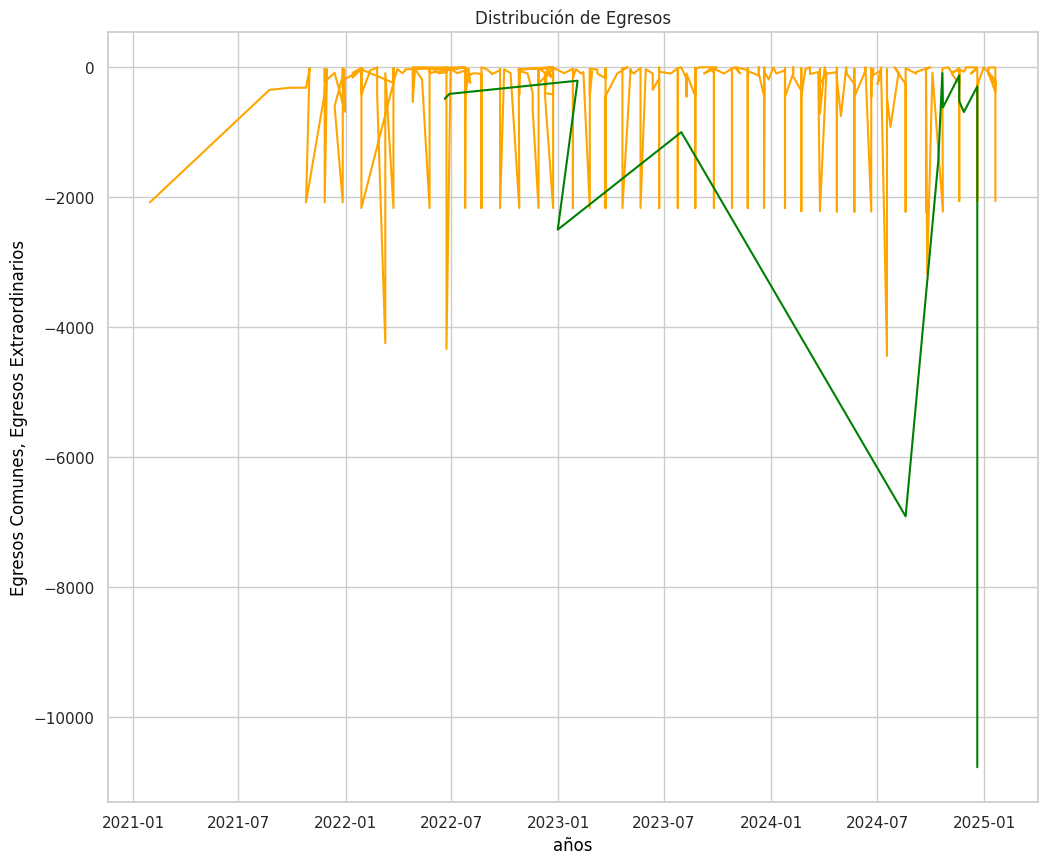

In [18]:
#Verificación de patrones temporales en data de entrenamiento y prueba
yEgCtn=fdfcp_train.query("categoria=='Egresos Comunes'")
yEgCtn=yEgCtn.dropna()
x1Egtn=yEgCtn.index
yEgCtn['diferencia']=yEgCtn['saldo'].astype(float)-yEgCtn['valor_pago'].astype(float)
y1Egtn=yEgCtn['diferencia']
yEgExtn=fdfcp_train.query("categoria=='Egresos Extraordinarios'")
yEgExtn=yEgExtn.dropna()
x2Egtn=yEgExtn.index
yEgExtn['diferencia']=yEgExtn['saldo'].astype(float)-yEgExtn['valor_pago'].astype(float)
y2Egtn=yEgExtn['diferencia']

yEgCts=fdfcp_test.query("categoria=='Egresos Comunes'")
yEgCts=yEgCts.dropna()
x1Egts=yEgCts.index
yEgCts['diferencia']=yEgCts['saldo'].astype(float)-yEgCts['valor_pago'].astype(float)
y1Egts=yEgCts['diferencia']
yEgExts=fdfcp_test.query("categoria=='Egresos Extraordinarios'")
yEgExts=yEgExts.dropna()
x2Egts=yEgExts.index
yEgExts['diferencia']=yEgExts['saldo'].astype(float)-yEgExts['valor_pago'].astype(float)
y2Egts=yEgExts['diferencia']

fig, ax = plt.subplots(figsize=(12, 10))
plt.title("Distribución de Egresos")
ax.set_ylabel('Egresos Comunes, Egresos Extraordinarios', color='black')
ax.set_xlabel('años', color='black')
plt.plot(x1Egtn, y1Egtn, color ="red")
plt.plot(x2Egtn, y2Egtn, color ="blue")
plt.plot(x1Egts, y1Egts, color ="orange")
plt.plot(x2Egts, y2Egts, color ="green")
plt.show()

##12. Lectura del Dataset Cuentas por Cobrar extraido de Sistema de Información Financiera para la administración de Condominios:
El dataset, es cargado totalmente en el repositorio Google Drive y este es obtenido del software de gestión contable de condominios, al leerlo se cargan la totalidad de los datos obtnidos de todos los condominios, se requiere realizar un filtrado por id de condominio y ciudad de ubicación, el cual se realizará con los resultados obtenidos del paso consulta de id's

In [19]:
df4 = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXcobrar_ingresos.csv')
df4.show()


+-------------+------+----------------+---------------+--------------------+----------+----------------+-----+-----+-----------+---------+----------+----------------------+
|id_condominio|id_cxc|       categoria|cuenta_contable|             detalle|     fecha|fechavencimiento|valor|saldo|fecha_cobro|descuento|valorcobro|diff_fecha_menos_cobro|
+-------------+------+----------------+---------------+--------------------+----------+----------------+-----+-----+-----------+---------+----------+----------------------+
|          467|334946|Ingresos Comunes|Consumo de Agua|Consumo de agua 1...|2019-01-01|      2019-01-31| 2.03| 0.00| 2019-07-09|     0.00|      2.03|                   189|
|          467|334948|Ingresos Comunes|Consumo de Agua|Consumo de agua 1...|2019-01-01|      2019-01-31| 3.85| 0.00| 2019-02-13|     0.00|      3.85|                    43|
|          467|334949|Ingresos Comunes|Consumo de Agua|Consumo de agua 1...|2019-01-01|      2019-01-31| 0.09| 0.00| 2019-03-12|     0.

## 13. Filtrado del dataset al tipo de condominio a Evaluar:
En este paso, se disgrega la consulta al tipo de condominio a evaluar por id's asociado a este tipo y ubicación.

In [20]:
df4.createOrReplaceTempView("cuentasXcobrar")

# Obtener todos los id_condominio como una tupla
id_condominios = tuple(X["id_condominio"].astype(str).tolist())

# Consulta única con WHERE IN
consulta = f"""
    SELECT id_condominio, id_cxc, categoria, cuenta_contable, fecha, fechavencimiento,
           valor, saldo, fecha_cobro, valorcobro
    FROM cuentasXcobrar
    WHERE id_condominio IN {id_condominios}
"""

# Ejecutar la consulta en Spark
sqlDF4 = spark.sql(consulta)

# Convertir directamente a Pandas
cuentascfin = sqlDF4.toPandas()

# Imprimir resultados
print(cuentascfin)
print("Total de Filas: " + str(len(cuentascfin)))


      id_condominio   id_cxc                 categoria       cuenta_contable  \
0              1111  1568808          Ingresos Comunes       Expensa Mensual   
1              1111  1568809          Ingresos Comunes       Expensa Mensual   
2              1111  1568810          Ingresos Comunes       Expensa Mensual   
3              1111  1568811          Ingresos Comunes       Expensa Mensual   
4              1111  1568812          Ingresos Comunes       Expensa Mensual   
...             ...      ...                       ...                   ...   
38447          1674  3883278  Ingresos Extraordinarios  Proyecto adoquinado    
38448          1674  3883274  Ingresos Extraordinarios           Parqueadero   
38449          1674  3940582  Ingresos Extraordinarios  Proyecto adoquinado    
38450          1674  3940714  Ingresos Extraordinarios  Proyecto adoquinado    
38451          1674  3940715  Ingresos Extraordinarios  Proyecto adoquinado    

            fecha fechavencimiento   va

## 14. Exploración de las Cuentas por Cobrar y sus saldos a lo largo de los años 2019 al 2024 del tipo de condominio seleccionado:
En este caso, se hace una exploración de las cuentas creadas en el tipo de condominio seleccionado, durante el período de años desde el 2019 al 2024, fechas de extracción de registros de la data.

Ingrese año a explorar:2023
Total de Filas: 0


[]

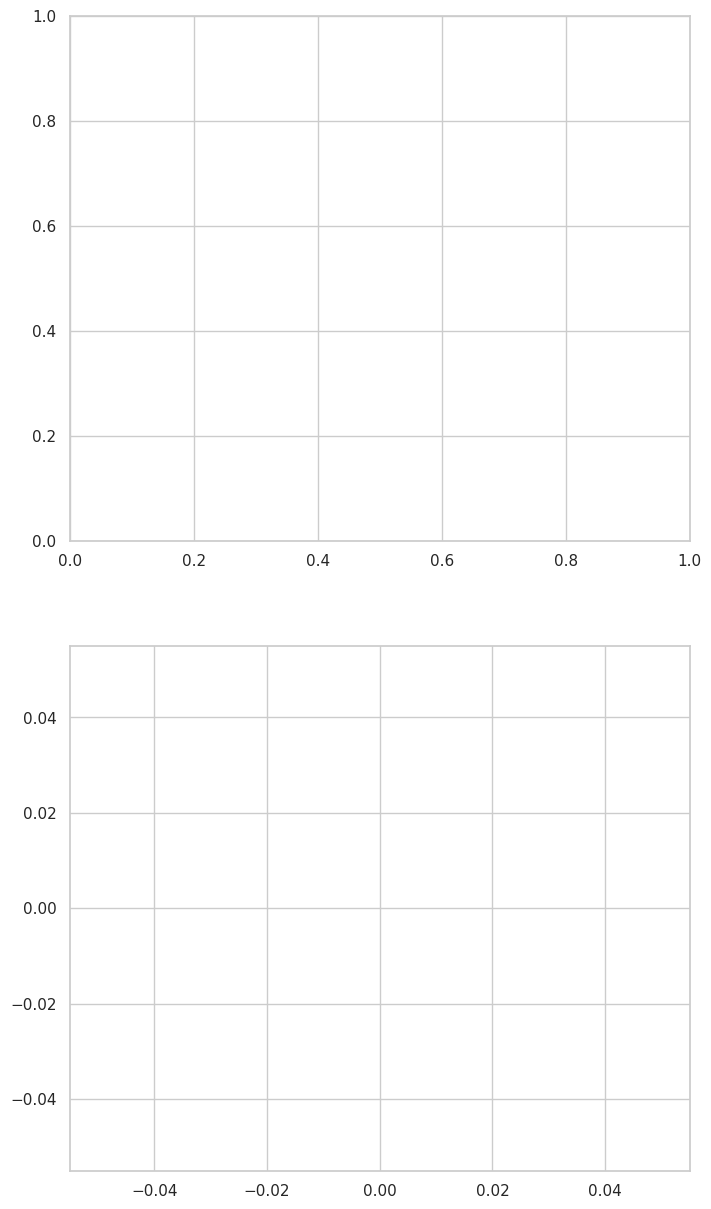

In [21]:

anoex = input("Ingrese año a explorar:")
dataexc=cuentascfin[(cuentascfin['fecha'] >='2024-01-01')& (cuentascfin['fecha'] <=f'{anoex}-12-31')]
print("Total de Filas: "+str(len(dataexc)))
fig, (ax1,ax2)= plt.subplots(2, 1,figsize=(8, 15))
sns.boxplot(x="categoria", y="id_condominio", data=dataexc, ax=ax1)
sns.swarmplot(x="categoria", y="id_condominio", data=dataexc, color='black', alpha = 0.5, ax=ax1)
plt.scatter(dataexc['id_condominio'],dataexc['cuenta_contable'])
ax2.plot()

## 15. Saldos de las cuentas por cobrar:
En este apartado se verfica el saldo pendiente de las cuentas por cobrar en el período seleccionado

Text(0, 0.5, 'Cuenta Contable')

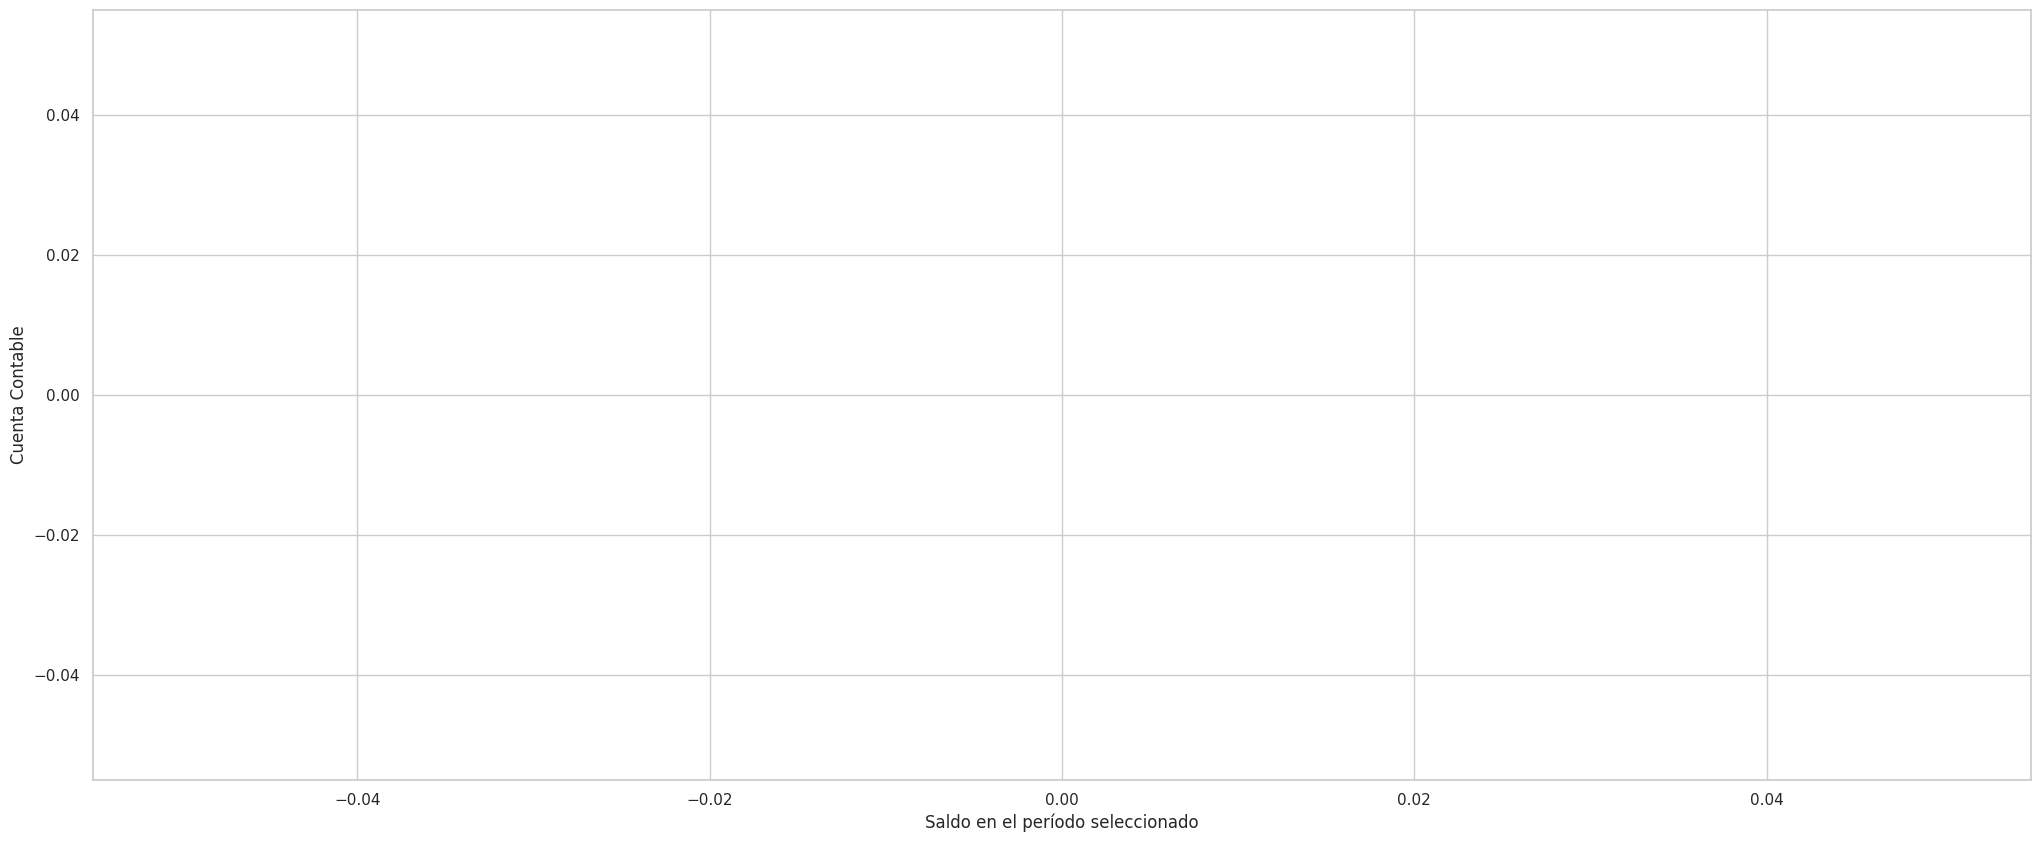

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(25,10))
ax.scatter(y=dataexc.cuenta_contable, x=dataexc.saldo, alpha= 0.8)
ax.set_xlabel('Saldo en el período seleccionado')
ax.set_ylabel('Cuenta Contable')

## 16.Series temporales para exploración de patrones de Ingresos:
En esta sección el usuario puede explorar el comportamiento de los Ingresos durante el tiempo de duración de la data extraída, en este caso para un id de condominio elegido de las consultas preliminares.

In [23]:
#Consulta cuentas por cobrar id_condominio
import datetime

# Configuración del estilo de Seaborn
sns.set(style="whitegrid")

# Visualización de la serie de tiempo
cuentascfin.head()
dfcc=pd.DataFrame({"id_condominio":cuentascfin["id_condominio"],
                   "categoria":cuentascfin["categoria"],
                   "saldo":cuentascfin["saldo"],
                   "fecha_cobro":cuentascfin["fecha_cobro"],
                   "valor":cuentascfin["valor"],
                   "valorcobro":cuentascfin["valorcobro"],
                   "id_cxc":cuentascfin["id_cxc"]})
print("coloque id de condominio a evaluar:")
id_filtrar=input()
query="id_condominio== \'"+id_filtrar+"\'"
fdfcc = dfcc.query(query)
fdfcc["fecha_cobro"] = pd.to_datetime(fdfcc["fecha_cobro"], format="%Y-%m-%d", errors="coerce")
fdfcc = fdfcc.set_index("fecha_cobro", drop='False')

coloque id de condominio a evaluar:
1073


<ipython-input-23-e508347bf266>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdfcc["fecha_cobro"] = pd.to_datetime(fdfcc["fecha_cobro"], format="%Y-%m-%d", errors="coerce")


In [24]:
#Partición de dataset
if len(fdfcc) < 2:
    print('la muestra está vacia o contiene datos insuficientes para realizar una proyección')
min_fechac = fdfcc.index.min()
print(min_fechac)
max_fechac= fdfcc.index.max()
print(max_fechac)
fdfcc_range_completo = pd.date_range(start=min_fechac, end=max_fechac, freq=fdfcc.index.freq)
print(len(fdfcc_range_completo))
freq_particion_train_c=int(len(fdfcc_range_completo)*0.60)
print(freq_particion_train_c)
freq_particion_test_c=int(len(fdfcc_range_completo))-freq_particion_train_c
print(freq_particion_test_c)
fdfcc_train = fdfcc[:-freq_particion_test_c]
#Partición entrenamiento
print(fdfcc_train)
fdfcc_test  = fdfcc[-freq_particion_test_c:]
#partición test
print(fdfcc_test)
print(f"Fechas train : {fdfcc_train.index.min()} --- {fdfcc_train.index.max()}  (n={len(fdfcc_train)})")
print(f"Fechas test  : {fdfcc_test.index.min()} --- {fdfcc_test.index.max()}  (n={len(fdfcc_test)})")

2021-11-01 00:00:00
2025-01-17 00:00:00
1174
704
470
            id_condominio                 categoria saldo   valor valorcobro  \
fecha_cobro                                                                    
2022-05-12           1073  Ingresos Extraordinarios  0.00  300.00     300.00   
2021-11-25           1073          Ingresos Comunes  0.00    0.20       0.20   
2021-11-25           1073          Ingresos Comunes  0.00   78.26      78.26   
2022-01-06           1073          Ingresos Comunes  0.00  957.60     957.60   
2021-11-25           1073          Ingresos Comunes  0.00  801.36     801.36   
...                   ...                       ...   ...     ...        ...   
2023-07-31           1073          Ingresos Comunes  0.00  263.34     263.34   
2023-07-10           1073          Ingresos Comunes  0.00  216.22     216.22   
2023-06-05           1073          Ingresos Comunes  0.00  212.98     212.98   
2023-06-05           1073          Ingresos Comunes  0.00  187.11  

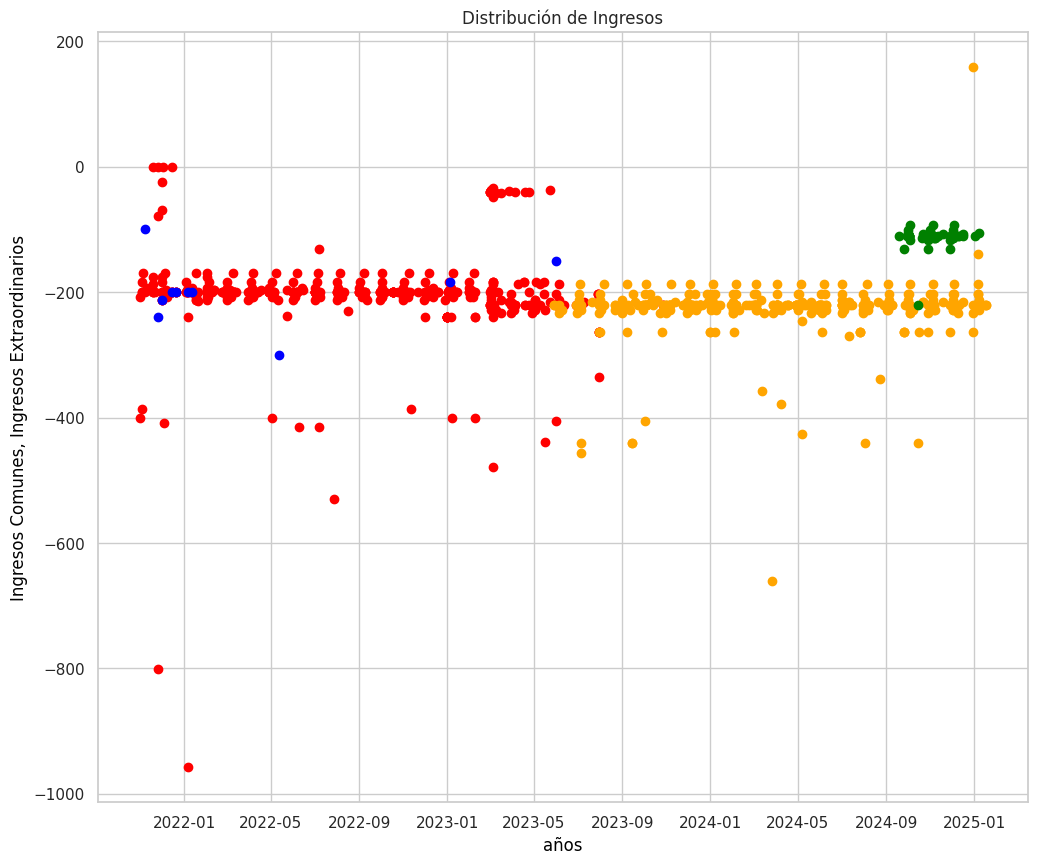

In [25]:
#Verificación de patrones temporales en data de entrenamiento y prueba para Ingresos
yIgCtn=fdfcc_train.query("categoria=='Ingresos Comunes'")
yIgCtn=yIgCtn.dropna()
x1Igtn=yIgCtn.index
yIgCtn['diferencia']=yIgCtn['saldo'].astype(float)-yIgCtn['valorcobro'].astype(float)
y1Igtn=yIgCtn['diferencia']
yIgExtn=fdfcc_train.query("categoria=='Ingresos Extraordinarios'")
yIgExtn=yIgExtn.dropna()
x2Igtn=yIgExtn.index
yIgExtn['diferencia']=yIgExtn['saldo'].astype(float)-yIgExtn['valorcobro'].astype(float)
y2Igtn=yIgExtn['diferencia']

yIgCts=fdfcc_test.query("categoria=='Ingresos Comunes'")
yIgCts=yIgCts.dropna()
x1Igts=yIgCts.index
yIgCts['diferencia']=yIgCts['saldo'].astype(float)-yIgCts['valorcobro'].astype(float)
y1Igts=yIgCts['diferencia']
yIgExts=fdfcc_test.query("categoria=='Ingresos Extraordinarios'")
yIgExts=yIgExts.dropna()
x2Igts=yIgExts.index
yIgExts['diferencia']=yIgExts['saldo'].astype(float)-yIgExts['valorcobro'].astype(float)
y2Igts=yIgExts['diferencia']

fig, ax = plt.subplots(figsize=(12, 10))
plt.title("Distribución de Ingresos")
ax.set_ylabel('Ingresos Comunes, Ingresos Extraordinarios', color='black')
ax.set_xlabel('años', color='black')
plt.scatter(x1Igtn, y1Igtn, color ="red")
plt.scatter(x2Igtn, y2Igtn, color ="blue")
plt.scatter(x1Igts, y1Igts, color ="orange")
plt.scatter(x2Igts, y2Igts, color ="green")
plt.show()

In [26]:
## Si se usa Google Colab
!pip install skforecast
!pip install surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505181 sha256=ef2e011df3d372a307d046acb18951bad0d7f1cbb1bc596f83209d5aba6fe80f
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## 17. Evaluación preliminar de algoritmos:
En esta etapa se aplican los modelos Forecasting multi step recursivo, Sarimax y Arimax, Redes Neuronales (Sequential) para evaluar su desempeño

En primera instancia se declaran las dependencias y la función de mostrar_distribución que se usa para mostrar los resultados de la predicción junto a la curva roc y demás métricas para evaluar los resultados

In [43]:
## Carga de Datos

from pyspark.sql.functions import col, regexp_replace, countDistinct, asc, desc, count, lit
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
#Cargar la data
data = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXcobrar_ingresos.csv')
data = data.filter(col("id_condominio").rlike("^[0-9]+$"))
data = data.filter(col("valor").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))

data1 = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXpagar_egresos.csv')
data1 = data1.filter(col("id_condominio").rlike("^[0-9]+$"))
data1 = data1.filter(col("valor").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))
data1 = data1.filter(col("valor_pago").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))

data_condominios = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'condominios.csv')
data_condominios = data_condominios.filter(col("id_condominio").rlike("^[0-9]+$"))
data_condominios = data_condominios.withColumn("avgcuota", col("avgcuota").cast(DoubleType()))

data_condominios.show()
data.show()
data1.show()

+-------------+--------------+----------+-----------+------+-------------+--------+--------+------------------+------------------+--------------------+
|id_condominio|tipocondominio|codlatitud|codlongitud|ciudad|totalunidades|mincuota|maxcuota|          avgcuota|totalcuota_mensual|               tipos|
+-------------+--------------+----------+-----------+------+-------------+--------+--------+------------------+------------------+--------------------+
|           15|  Urbanización|    -0.227|    -78.444| Quito|          186|    0.00|  165.00|35.564516129032256|           6615.00| Lote: 30| Casa: 156|
|           42|  Urbanización|     -0.09|    -80.187|  Jama|          115|    0.00|  228.62|100.32313043478261|          11537.16|           Lote: 115|
|           47|      Edificio| -0.169713| -78.476977| Quito|           72|   41.46|  151.96| 73.62833333333333|           5301.24|    Departamento: 72|
|           48|      Edificio|    -0.178|    -78.481| Quito|           45|    0.00|  376

In [46]:
## Conversión de variables

columnas_convertir_1 = ["totalunidades", "mincuota", "maxcuota", "avgcuota", "totalcuota_mensual"]
columnas_convertir_2 = ["valor", "saldo", "descuento", "valorcobro", "diff_fecha_menos_cobro"]
columnas_convertir_3 = ["valor", "saldo", "valor_pago", "diff_fecha_menos_pago"]

for columna in columnas_convertir_1:
    data_condominios = data_condominios.withColumn(columna, col(columna).cast("float"))

for columna in columnas_convertir_2:
    data = data.withColumn(columna, col(columna).cast("float"))

for columna in columnas_convertir_3:
    data1 = data1.withColumn(columna, col(columna).cast("float"))

data_condominios.printSchema()
data.printSchema()
data1.printSchema()

root
 |-- id_condominio: string (nullable = true)
 |-- tipocondominio: string (nullable = true)
 |-- codlatitud: float (nullable = true)
 |-- codlongitud: float (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- totalunidades: float (nullable = true)
 |-- mincuota: float (nullable = true)
 |-- maxcuota: float (nullable = true)
 |-- avgcuota: float (nullable = true)
 |-- totalcuota_mensual: float (nullable = true)
 |-- tipos: string (nullable = true)

root
 |-- id_condominio: string (nullable = true)
 |-- id_cxc: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- cuenta_contable: string (nullable = true)
 |-- detalle: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- fechavencimiento: string (nullable = true)
 |-- valor: float (nullable = true)
 |-- saldo: float (nullable = true)
 |-- fecha_cobro: string (nullable = true)
 |-- descuento: float (nullable = true)
 |-- valorcobro: float (nullable = true)
 |-- diff_fecha_menos_cobro: float (nul

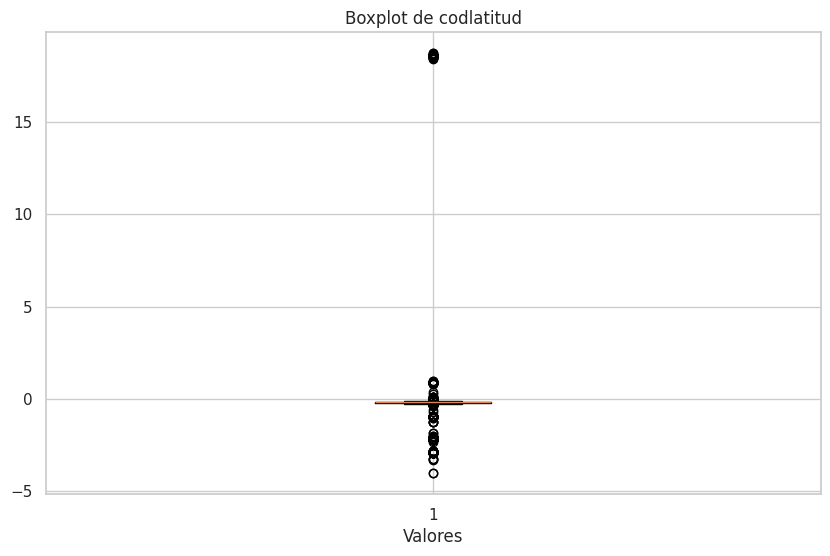

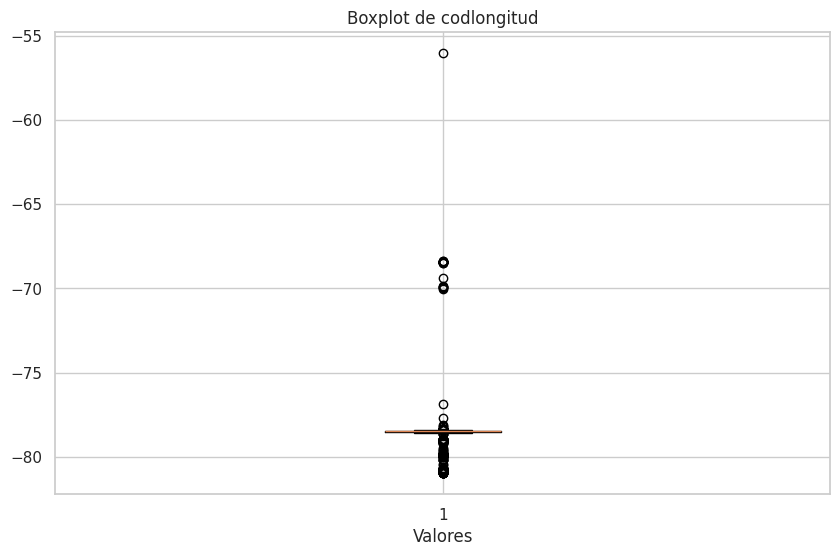

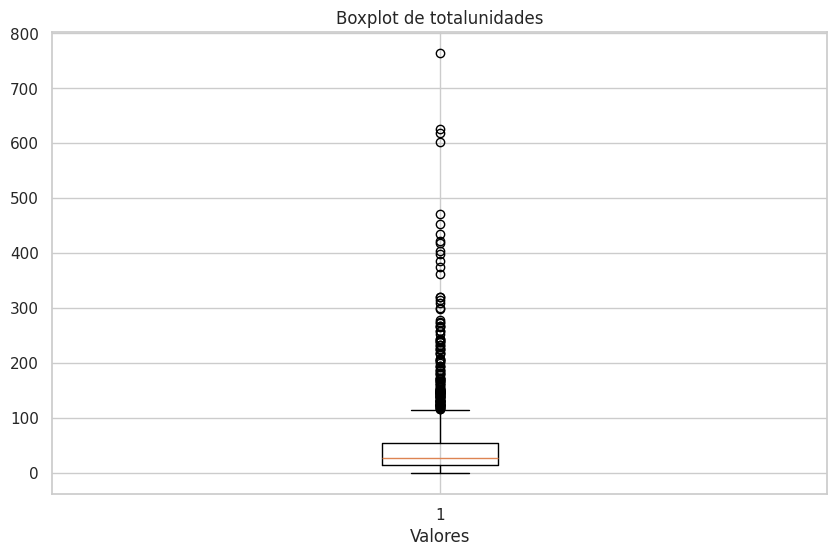

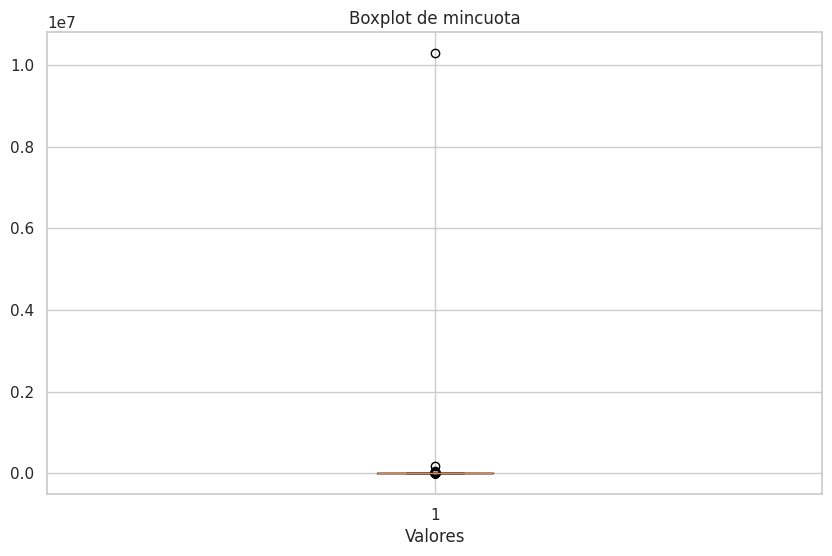

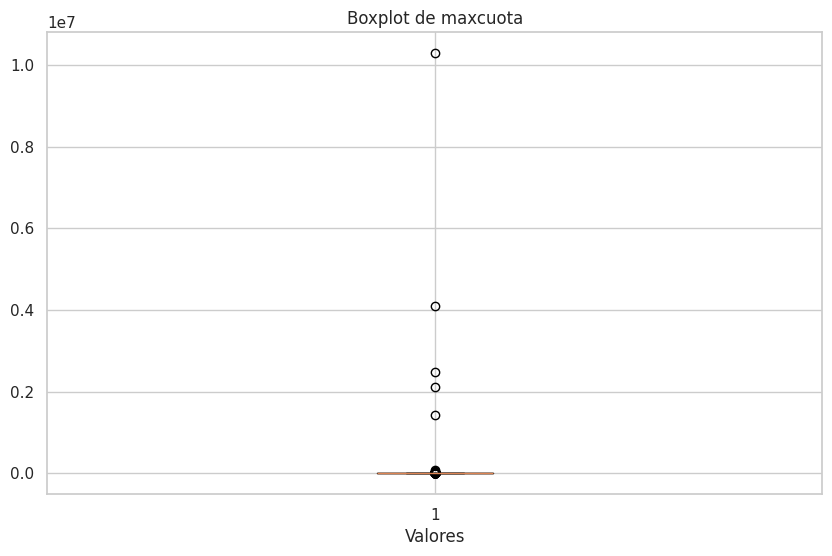

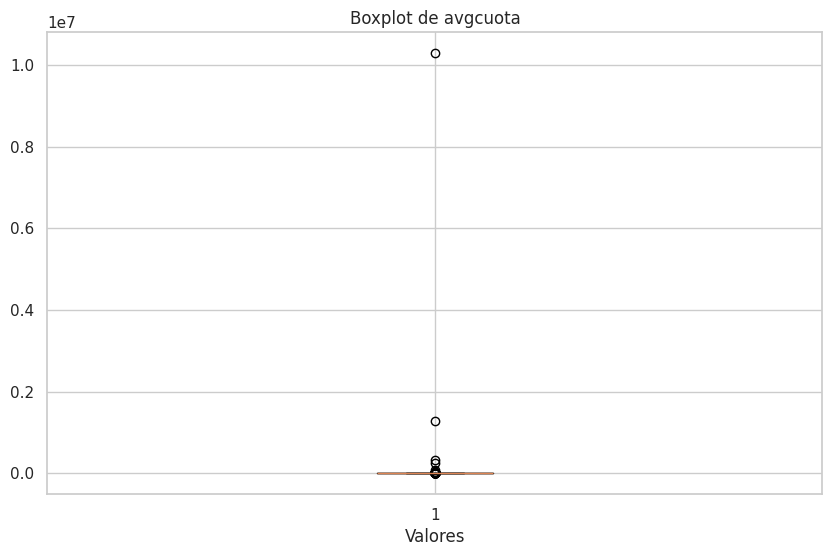

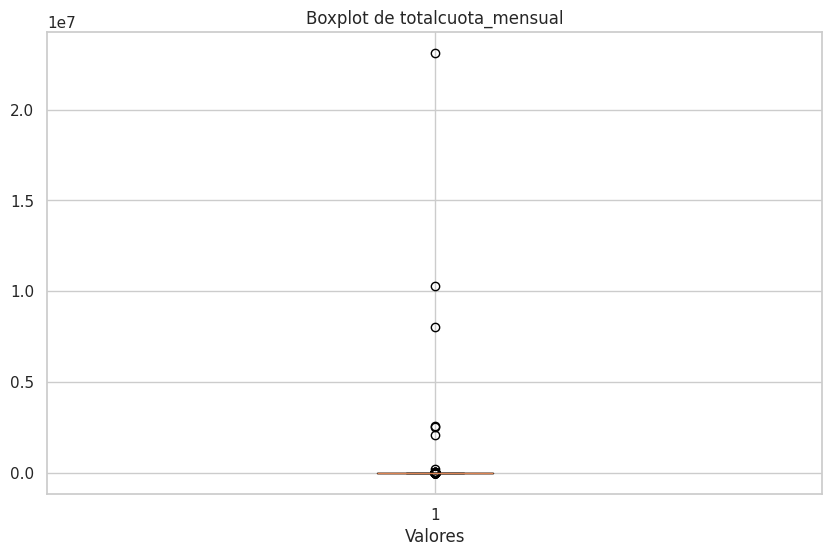

In [53]:
## Detección de Valores atípicos
from pyspark.sql.functions import col
import pyspark.sql.functions as F

columnas_flotantes = [campo[0] for campo in data_condominios.dtypes if campo[1] == 'double' or campo[1] == 'float']

df_pandas = data_condominios.toPandas()

for columna in columnas_flotantes:
    plt.figure(figsize=(10, 6))
    plt.boxplot(df_pandas[columna].dropna())
    plt.xlabel('Valores')
    plt.title(f'Boxplot de {columna}')
    plt.show()


In [55]:
## Detección de Datos Faltantes

from pyspark.sql.functions import col, sum

# Contar los datos faltantes en cada columna
data_condominios.select([sum(col(c).isNull().cast("int")).alias(c) for c in data_condominios.columns]).show()

# Contar los datos faltantes en cada columna
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

# Contar los datos faltantes en cada columna
data1.select([sum(col(c).isNull().cast("int")).alias(c) for c in data1.columns]).show()

+-------------+--------------+----------+-----------+------+-------------+--------+--------+--------+------------------+-----+
|id_condominio|tipocondominio|codlatitud|codlongitud|ciudad|totalunidades|mincuota|maxcuota|avgcuota|totalcuota_mensual|tipos|
+-------------+--------------+----------+-----------+------+-------------+--------+--------+--------+------------------+-----+
|            0|             0|         0|          0|     0|            0|       0|       0|       0|                 0|    8|
+-------------+--------------+----------+-----------+------+-------------+--------+--------+--------+------------------+-----+

+-------------+------+---------+---------------+-------+-----+----------------+-----+-----+-----------+---------+----------+----------------------+
|id_condominio|id_cxc|categoria|cuenta_contable|detalle|fecha|fechavencimiento|valor|saldo|fecha_cobro|descuento|valorcobro|diff_fecha_menos_cobro|
+-------------+------+---------+---------------+-------+-----+------

In [56]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, svm
from sklearn.svm import SVC
from sklearn.cluster import KMeans

# skforecast
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
import shap

#Sarimax
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from numpy.linalg import LinAlgError

import warnings
warnings.filterwarnings('once')

import math


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

#definición de la función para mostrar los gráficos y realizar las comparaciones entre los distintos modelos
def mostrar_distribucion(y_train, y_test, predicciones, margin_error_prc = .15):
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.title("Distribución de Ingresos/Egresos")
    ax.set_ylabel('Ingresos/Egresos Comunes y Extraordinarios', color='black')
    ax.set_xlabel('años', color='black')
    y_train.plot(ax=ax, label ="train")
    y_test.plot(ax=ax, label ="test")
    predicciones.plot(ax=ax, label='predicciones')
    ax.legend()
    plt.show()

    # Calcular el umbral para la curva ROC
    # El Umbral se calcula porcentualmente entre el valor más grande y el más pequeño de entre la data de entrenamiento
    umbral_min = y_test.min()
    umbral_max = y_test.max()
    #umbral = (umbral_max - umbral_min)*margin_error_prc
    umbral = abs(y_train.values.mean())*margin_error_prc

    print(f" tamaño de muestra de prueba: {len(y_test)}, tamaño de predicciones: {len(predicciones)}")
    # Calcular la clasificación de falsos positivos y verdaderos positivos para la curva ROC
    clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]

    #diferencias = [abs(y_test[i] - predicciones.values[i]) for i in range(len(y_test))]
    #diferencias_normalizadas = diferencias/umbral   # Normalizar al rango [0, 1]
    max_prediccion = max(predicciones.values)
    puntuaciones_clasificacion = [predicciones.values[i] / max_prediccion for i in range(len(y_test))]
    #puntuaciones_clasificacion = predicciones

    #print(diferencias)
    print(clasificacion)
    print(puntuaciones_clasificacion)
    print(f"el umbral de error de la curva roc es de {umbral}")

    # Calcular la curva ROC
    fpr, tpr, umbrales = roc_curve(clasificacion, predicciones)

    # Calcular el área bajo la curva ROC (AUC)
    auc = roc_auc_score(clasificacion, predicciones)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Error test
    error_mse = mean_squared_error(
                    y_true = y_test,
                    y_pred = predicciones
                )
    # Promedio de error absoluto
    error_mae = mean_absolute_error(y_test, predicciones)
    # Coeficiente de determinación
    r2 = r2_score(y_test, predicciones)
    print(f"Error de test (mse): {error_mse}")
    print(f"Error de test (mae): {error_mae}")
    print(f"Coeficiente de determinación (R²): {r2}")
    print(f"Área debajo de la curva ROC (ROC AUC): {auc}")
    return {
        "mse" : error_mse,
        "mae" : error_mse,
        "r2" : r2,
        "auc": auc
    }

Se carga la data a evaluar para ser procesada y se depuran las id de los elementos

In [57]:

from pyspark.sql.functions import col, regexp_replace, countDistinct, asc, desc, count, lit
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
#Cargar la data
data = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXcobrar_ingresos.csv')
data = data.filter(col("id_condominio").rlike("^[0-9]+$"))
data = data.filter(col("valor").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))

data1 = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'cuentasXpagar_egresos.csv')
data1 = data1.filter(col("id_condominio").rlike("^[0-9]+$"))
data1 = data1.filter(col("valor").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))
data1 = data1.filter(col("valor_pago").rlike("^[+-]?([0-9]*[.])?[0-9]+$"))

data_condominios = spark.read.option("delimiter", delimiter).option("header", True).csv(rootDir + 'condominios.csv')
data_condominios = data_condominios.filter(col("id_condominio").rlike("^[0-9]+$"))
data_condominios = data_condominios.withColumn("avgcuota", col("avgcuota").cast(DoubleType()))

Buscar condominios por tipo y ciudad (Opcional)

In [58]:
# Filtrar data_condominios por ciudad y tipo de condominio
# (Se pueden dejar las variables vacias para obviar el filtro)
#
# Ciudades:
# Jaramijo, Macas, Cuenca, Same, Santo Domingo, Quito, Portoviejo, Pedro Vicente Maldonado, Manta, Tulcan,
# Sucre, Guayaquil, Loja, Milagro, Santa Elena, Ibarra, Atacames, Tonsupa, Jama,
# Ambato, Chone, Machala, Daule, La Libertad, Duran, Salinas, Pedernales, Pedro Moncayo, Rumiñahui,
# Palestina, Lago Agrio, Samborondon, Babahoyo, Mejia, Esmeraldas
#
# Tipos de condominio:
# Centro Comercial, Urbanización, Cowork, Condominio, Conjunto, Edificio, Lotización, Consultorios Médicos, Cuenta
ciudad_filtro = "Quito"  # Reemplaza con la ciudad que deseas filtrar
tipo_condominio_filtro = "Condominio"  # Reemplaza con el tipo de condominio que deseas filtrar

#Obtención de opciones para la validación
tipos_condominios = data_condominios.groupBy("tipocondominio").count()
opciones_condominios = [row["tipocondominio"] for row in tipos_condominios.select("tipocondominio").collect()]

ciudades = data_condominios.groupBy("ciudad").count()
opciones_ciudades = [row["ciudad"] for row in ciudades.select("ciudad").collect()]

#Validaciones de entradas
if(ciudad_filtro not in opciones_ciudades):
    print(f"\033[31mLa ciudad que ingresó '{ciudad_filtro}' no se encuentra en la base de datos, las entradas disponibles son:")
    print(f"\033[31m {', '.join(opciones_ciudades)}")
    raise SystemExit

if(tipo_condominio_filtro not in opciones_condominios):
    print(f"\033[31mEl tipo de condominio que ingresó '{tipo_condominio_filtro}' no se encuentra en la base de datos, las entradas disponibles son:")
    print(f"\033[31m {', '.join(opciones_condominios)}")
    raise SystemExit


# Crear una condición base que siempre sea verdadera (1 == 1)
condicion = lit(True)

# Añadir condiciones solo si los filtros no están vacíos
if ciudad_filtro:
    condicion = condicion & (col("ciudad") == ciudad_filtro)

if tipo_condominio_filtro:
    condicion = condicion & (col("tipocondominio") == tipo_condominio_filtro)


data_condominios.filter(condicion).orderBy(desc("avgcuota")).show()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=68, family=2, type=1, proto=6, laddr=('127.0.0.1'

+-------------+--------------+--------------------+------------------+------+-------------+--------+--------+------------------+------------------+--------------------+
|id_condominio|tipocondominio|          codlatitud|       codlongitud|ciudad|totalunidades|mincuota|maxcuota|          avgcuota|totalcuota_mensual|               tipos|
+-------------+--------------+--------------------+------------------+------+-------------+--------+--------+------------------+------------------+--------------------+
|         1556|    Condominio|   -2.18294638091665|-79.89558980600616| Quito|           11|    0.00| 1300.00| 693.7272727272727|           7631.00|Departamento: 2| ...|
|         1864|    Condominio|-0.19786036884032518|-78.47937554794308| Quito|           23|   25.00|  780.00|330.14217391304345|           7593.27|Departamento: 20|...|
|         1552|    Condominio|-0.11489745450062057|-78.47708229391272| Quito|           42|  149.31|  447.23| 260.1907142857143|          10928.01|        

Este código muestra las id de condominios con mayor cantidad de registros (Opcional)

In [59]:
#Mostrar condominios con más registros agrupados por id_condominio, contar y obtener la fecha mínima
data.groupBy("id_condominio").agg(
        count("*").alias("registros"),
        F.min("fecha").alias("fecha_mas_antigua"),
        F.sum("valorcobro").alias("ingresos_totales")
    ).orderBy(desc("registros"), asc("fecha_mas_antigua")).show()

data1.groupBy("id_condominio").agg(
        count("*").alias("registros"),
        F.min("fecha").alias("fecha_mas_antigua"),
        F.sum("valor_pago").alias("egresos_totales")
    ).orderBy(desc("registros"), asc("fecha_mas_antigua")).show()

+-------------+---------+-----------------+------------------+
|id_condominio|registros|fecha_mas_antigua|  ingresos_totales|
+-------------+---------+-----------------+------------------+
|          265|    39019|       2019-01-01|1787551.9100000062|
|          347|    27352|       2019-01-01|          473184.5|
|          715|    26567|       2020-01-01|1680481.2900000187|
|          320|    24197|       2019-01-01|  572773.070000009|
|          402|    23436|       2019-01-01|1013652.8399999995|
|          904|    22003|       2019-01-01|1996158.7000000058|
|         1417|    21550|       2019-01-04|1184451.6400000085|
|          171|    19991|       2019-01-03| 892343.2699999737|
|          306|    17838|       2019-01-01| 845888.5500000002|
|          668|    17482|       2020-03-01|1534342.4300000065|
|         1057|    16805|       2019-01-01|         593086.71|
|          283|    16702|       2019-01-01|1205943.5799999959|
|          732|    16144|       2020-07-01|418159.36999

Aquí se modifican las variables que afectan directamente a los resultados de las predicciones y se prepara la data para ser evaluada

In [60]:
# Condominios a comparar, el primero que se declare será el que se use para la predicción
# Los demás se usarán para realizar comparaciones
id_condominios = [285, 156, 334]
#frecuencia de visualización de los datos (W,2W,M)
frequency = '2W'
#porcentaje de margen de error para la evaluación del modelo
margen_error_roc = .05
#margen de particion para la muestra de entrenamiento
margen_particion_ent = .8
#Tipo de data a analizar, 0 = monto consolidado, 1 = ingresos, 2 = egresos
tipo_data = 1
#Parámetro para evaluar la precisión del modelo pueden ser: mae (Mean Absolute Error), mse (Error Cuadrático Medio), auc (Área bajo la Curva ROC), y r2 (Coeficiente de Determinación)
#Este parámetro es el que se usará para evaluar los modelos
parametro_evaluar = "r2"

#Obtención de opciones para la validación de las ids de condominios
todas_ids_condominios = data_condominios.groupBy("id_condominio").count()
todas_opciones_condominios = [int(row["id_condominio"]) for row in todas_ids_condominios.select("id_condominio").collect()]

# Validación ids de condominios
validacion_ids = set(id_condominios) - set(todas_opciones_condominios)
if(len(validacion_ids) > 0):
   ids = [str(val) for val in validacion_ids]
   print(f"\033[31mLos condominios {', '.join(ids)} no se encuentran en la base de datos")
   raise SystemExit

# Condominio a evaluar (también se usará para la predicción)
id_condominio = id_condominios[0]

pd_data = data.filter(col("id_condominio") == id_condominio).toPandas()
pd_data1 = data1.filter(col("id_condominio") == id_condominio).toPandas()
pd_condominio = data_condominios.filter(col("id_condominio") == id_condominio).toPandas()
if(tipo_data == 0):
   pd_data['diferencia'] = pd_data['valorcobro'].astype(float) - pd_data1['valor_pago'].astype(float)
if(tipo_data == 1):
   pd_data['diferencia'] = pd_data['valorcobro'].astype(float)
if(tipo_data == 2):
   pd_data1['diferencia'] = -pd_data1['valor_pago'].astype(float)
#pd_data = pd_data.groupby('fecha_cobro').sum()

/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=68, family=2, type=1, proto=6, laddr=('127.0.0.1', 34788), raddr=('127.0.0.1', 46211)>
  self._sock = None
/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=68, family=2, type=1, proto=6, laddr=('127.0.0.1', 40666), raddr=('127.0.0.1', 46133)>
  self._sock = None
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=68, family=2, type=1, proto=6, laddr=('127.0.0.1', 47038), raddr=('127.0.0.1', 36831)>
  self._sock = None
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=68, family=2, type=1, proto=6, laddr=('127.0.0.1', 58340), raddr=('127.0.0.1', 37901)>
  self._sock = None


Se filtra y procesa la data para realizar las predicciones con los diferentes modelos con la finalidad de evaluarlos en el conjunto de datos

seasonal order frecuency: 27
min_fecha: 2019-01-06 00:00:00, max_fecha: 2025-01-26 00:00:00
tamaño de muestra de entrenamiento: 127
tamaño de muestra de prueba: 32
tamaño de muestra total: 159
Uso del modelo ForecasterRecursive con RandomForestRegressor
Buscando mejor configuración de Hiperparámetros...


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


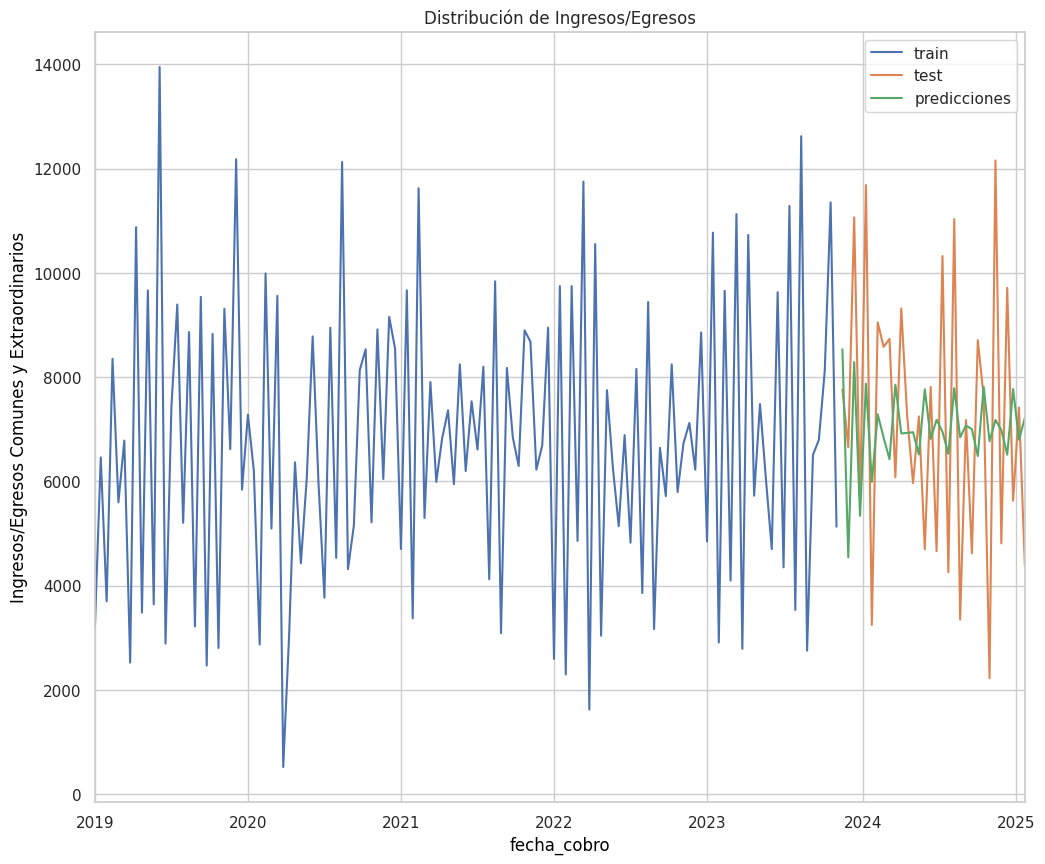

 tamaño de muestra de prueba: 32, tamaño de predicciones: 32
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1.0, 0.5321902362620256, 0.9711929192226318, 0.625364573308258, 0.9226195640188737, 0.7018287753130145, 0.8536586934308196, 0.801577087026766, 0.7527805487241264, 0.9201822040785179, 0.8106913544595996, 0.8119191563551801, 0.813527852770478, 0.7634218630773045, 0.9100481233827356, 0.7986785354596643, 0.8414641822704287, 0.814524200232771, 0.7649001843969804, 0.9124337890037327, 0.8020530669304381, 0.8285862030592496, 0.8201349971106546, 0.7600492664153959, 0.9157575644573674, 0.7932063752738681, 0.841028760625298, 0.8184374630793793, 0.7630403844345997, 0.9105449928855157, 0.7965787629467308, 0.8458129282869806]
el umbral de error de la curva roc es de 336.79452362204734


<ipython-input-56-b56f1a7f4a30>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]


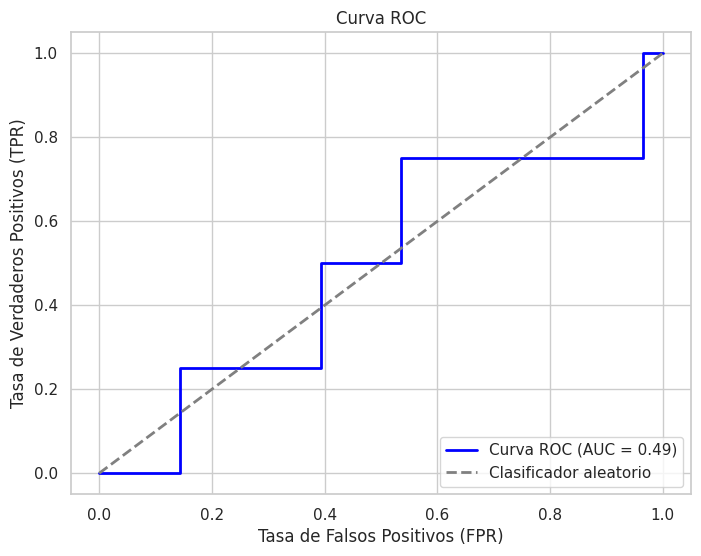

Error de test (mse): 6156069.330848068
Error de test (mae): 2151.1992676773316
Coeficiente de determinación (R²): 0.06545658261928566
Área debajo de la curva ROC (ROC AUC): 0.4910714285714286
Uso del modelo ForecasterRecursive con LinearRegresion y SVD


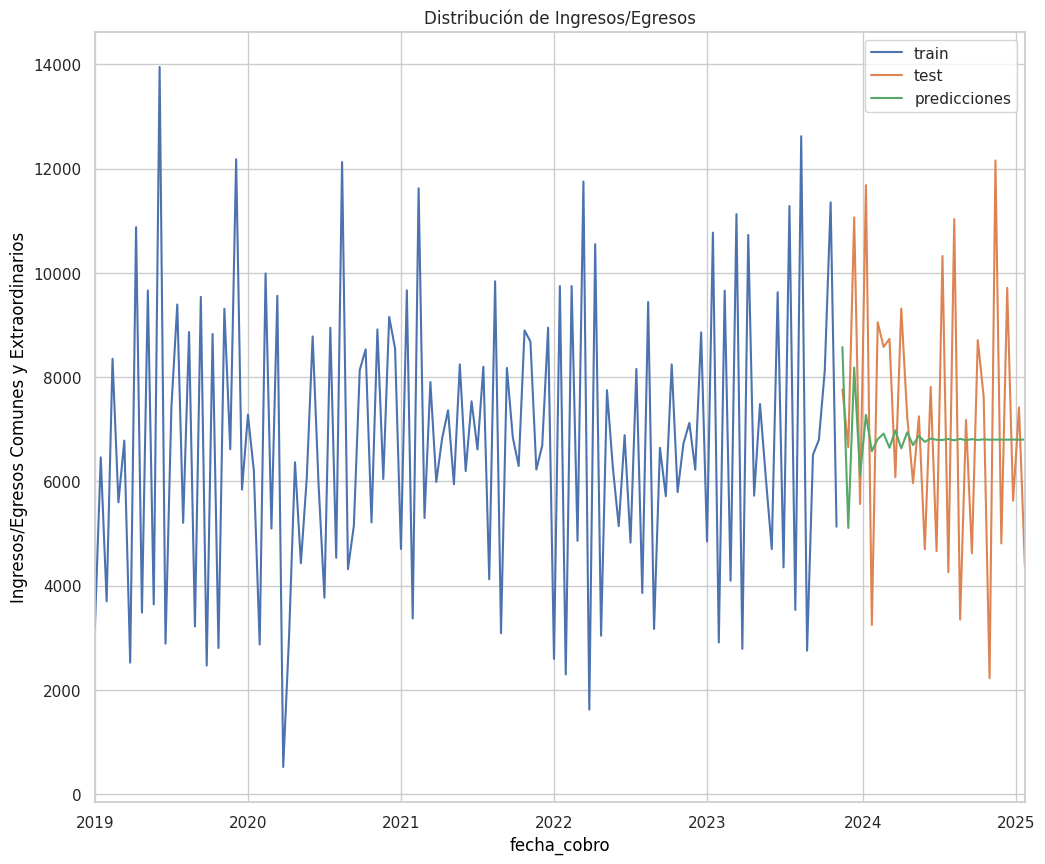

 tamaño de muestra de prueba: 32, tamaño de predicciones: 32
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 0.5953362777226326, 0.9542451042262428, 0.7127719058092604, 0.8483048491593125, 0.7671650101878371, 0.7938651637404057, 0.8064163155881597, 0.7747766504327743, 0.8137007294747839, 0.7733915755299917, 0.8091973891900157, 0.7807593267631555, 0.8014808053761391, 0.7879099571565656, 0.7953788950462511, 0.7925188458886732, 0.7922447529598473, 0.7944112435646761, 0.7913449949392684, 0.7945850121095636, 0.7916292095011752, 0.7940569707926938, 0.7922448657490028, 0.7934621659366545, 0.7927544421119473, 0.7930657449028468, 0.7930341420780415, 0.7928911765683361, 0.793123464150291, 0.792864619316365, 0.7931084825911063]
el umbral de error de la curva roc es de 336.79452362204734


<ipython-input-56-b56f1a7f4a30>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]


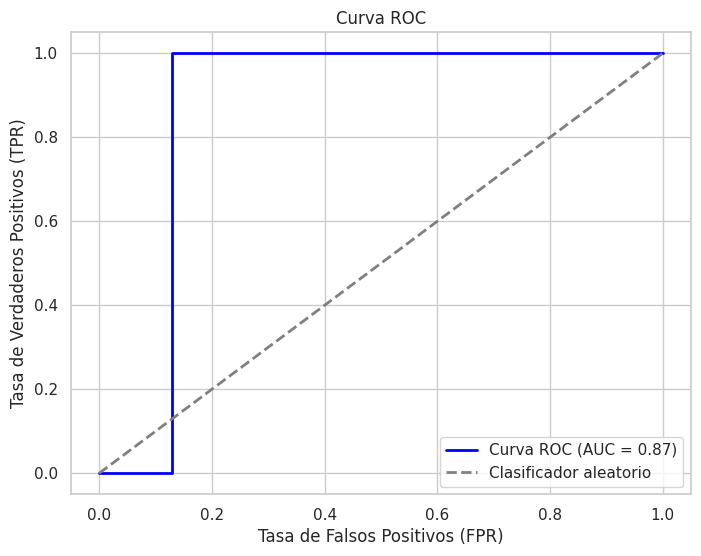

Error de test (mse): 6279217.158286354
Error de test (mae): 2121.29563365571
Coeficiente de determinación (R²): 0.04676170033125093
Área debajo de la curva ROC (ROC AUC): 0.8709677419354839
Buscando la mejor configuración de hiperparámetros para Arima y Sarimax


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap

Uso del modelo SARIMAX


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen i

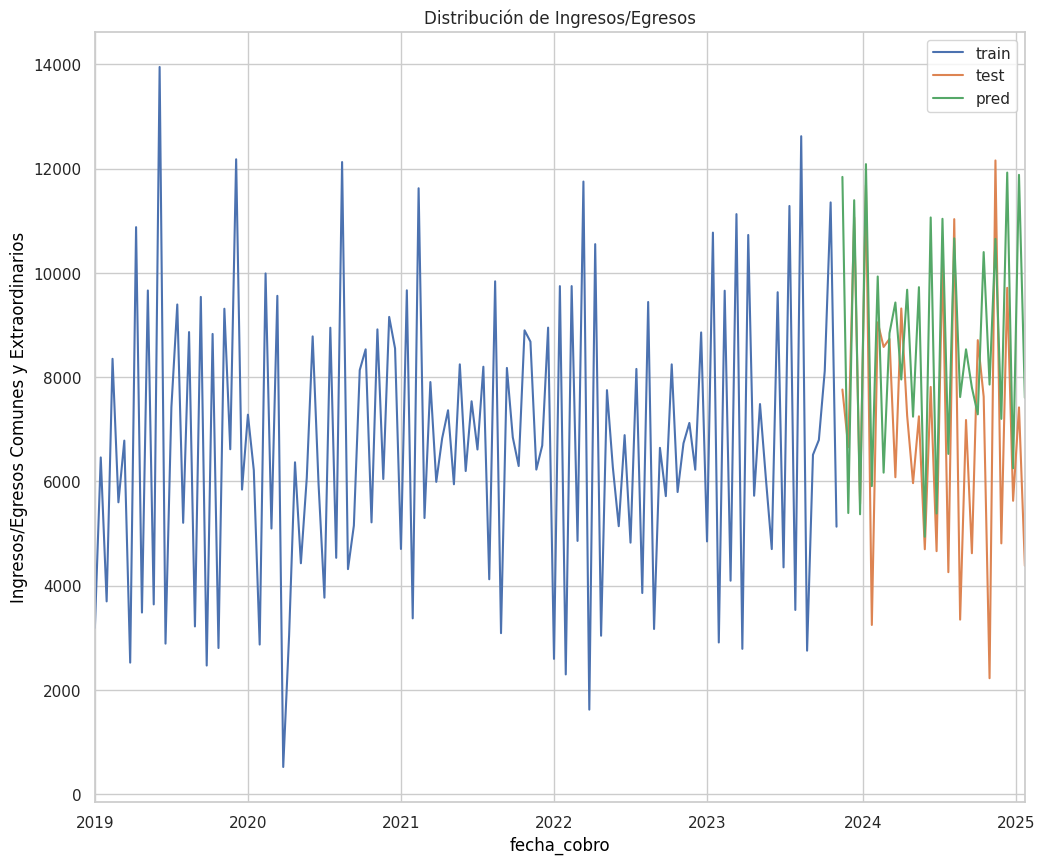

 tamaño de muestra de prueba: 32, tamaño de predicciones: 32
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([0.97971238]), array([0.44611868]), array([0.94271564]), array([0.44410929]), array([1.]), array([0.48880861]), array([0.82161904]), array([0.51020925]), array([0.73166066]), array([0.78030368]), array([0.65810314]), array([0.80059056]), array([0.59907455]), array([0.8046645]), array([0.40848405]), array([0.91533898]), array([0.44537529]), array([0.91320641]), array([0.53996139]), array([0.88212307]), array([0.63023808]), array([0.7059626]), array([0.64512594]), array([0.60278894]), array([0.86035908]), array([0.65005186]), array([0.88133848]), array([0.5955549]), array([0.98658354]), array([0.51718936]), array([0.9829798]), array([0.62896419])]
el umbral de error de la curva roc es de 336.79452362204734


<ipython-input-56-b56f1a7f4a30>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]


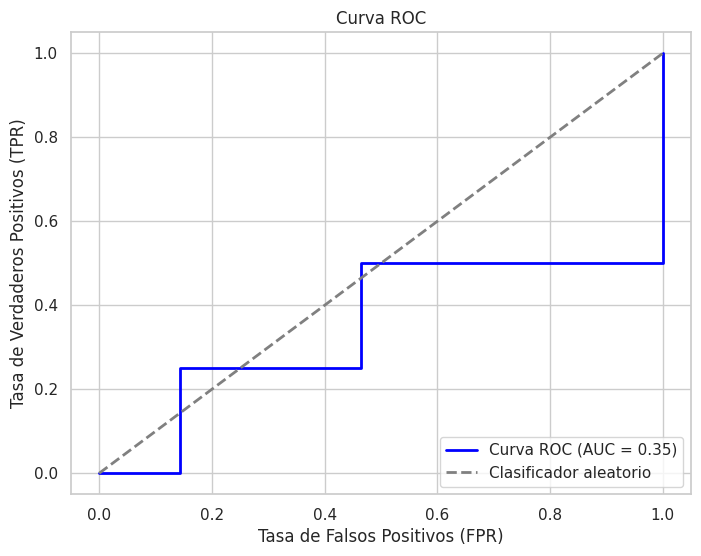

Error de test (mse): 5970313.907808768
Error de test (mae): 1994.8114529830618
Coeficiente de determinación (R²): 0.09365582770807246
Área debajo de la curva ROC (ROC AUC): 0.3482142857142857
Uso del modelo ARIMAX


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregr

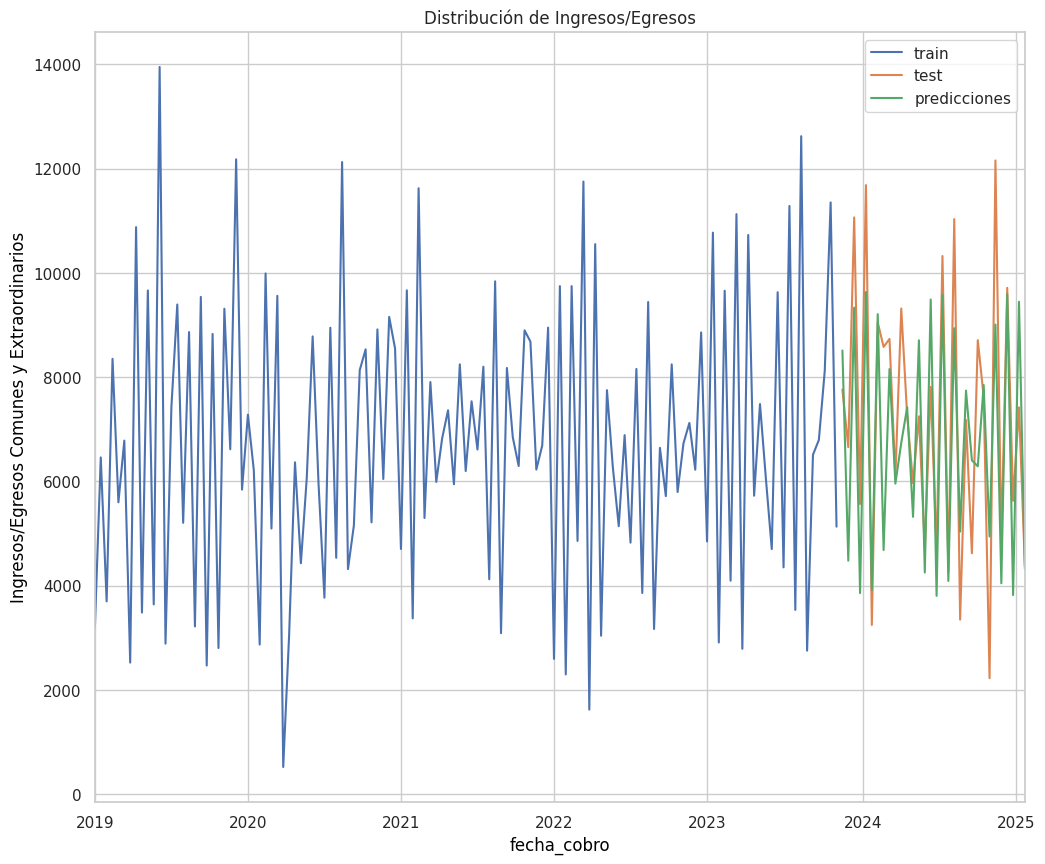

 tamaño de muestra de prueba: 32, tamaño de predicciones: 32
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
[0.8834596367549864, 0.4648399667966223, 0.968845985938806, 0.4002506161130523, 1.0, 0.40671058464872534, 0.9557844234542003, 0.4859876863331024, 0.8464904675647174, 0.618307138163361, 0.6996149553908337, 0.7703388204567273, 0.5521544419413891, 0.9037961211759113, 0.4412337054566799, 0.9850912860570998, 0.39475570785615915, 0.9937894731502277, 0.42438217705094955, 0.9277454122804555, 0.5226076082513413, 0.8036322697094712, 0.6646606217342891, 0.6527324520581075, 0.8147510129817364, 0.5130529706500059, 0.9350870671011641, 0.41975266083596147, 0.9953912356922185, 0.3962923377590632, 0.9805182018940125, 0.4485354826269255]
el umbral de error de la curva roc es de 336.79452362204734


<ipython-input-56-b56f1a7f4a30>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]


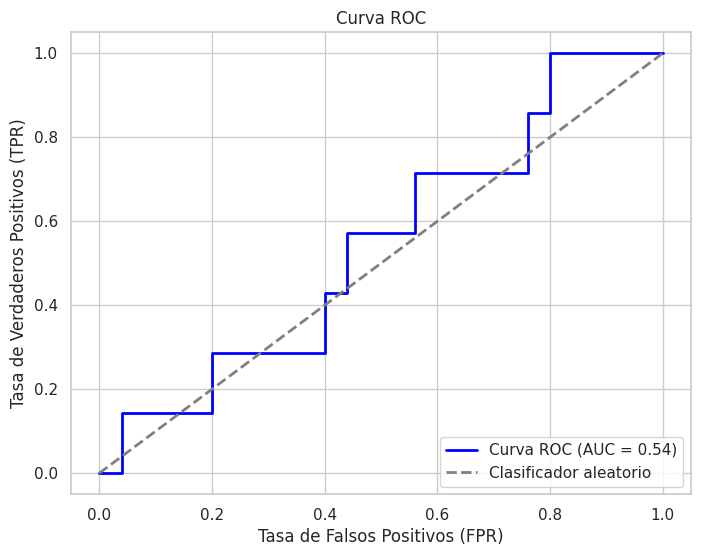

Error de test (mse): 2716100.943611402
Error de test (mae): 1312.8165477642203
Coeficiente de determinación (R²): 0.5876728929815511
Área debajo de la curva ROC (ROC AUC): 0.5428571428571428
{'ForecasterRecursive con RandomForestRegressor': {'mse': 6156069.330848068, 'mae': 6156069.330848068, 'r2': 0.06545658261928566, 'auc': 0.4910714285714286}, 'ForecasterRecursive con LinearRegresion y SVD': {'mse': 6279217.158286354, 'mae': 6279217.158286354, 'r2': 0.04676170033125093, 'auc': 0.8709677419354839}, 'Sarimax': {'mse': 5970313.907808768, 'mae': 5970313.907808768, 'r2': 0.09365582770807246, 'auc': 0.3482142857142857}, 'Arimax': {'mse': 2716100.943611402, 'mae': 2716100.943611402, 'r2': 0.5876728929815511, 'auc': 0.5428571428571428}}

El mejor modelo tomando en cuenta el criterio de evaluación r2 es: Arimax
Métricas del mejor modelo: {'mse': 2716100.943611402, 'mae': 2716100.943611402, 'r2': 0.5876728929815511, 'auc': 0.5428571428571428}


In [61]:

fechas = pd.date_range(start='2023-01-01', end='2023-12-31', freq=frequency)
# Este es el orden de frecuencia que usa el modelo SARIMAX
seasonal_order_frequency = len(fechas)
print(f"seasonal order frecuency: {seasonal_order_frequency}")

# Se toma el conjunto de datos
if(tipo_data == 2):
   # Se convierte la columna de fecha de pago (string) a fecha (datetime)
   pd_data1['fecha_pago'] = pd.to_datetime(pd_data1['fecha_pago'])
   y = pd_data1.set_index('fecha_pago')['diferencia']
else:
   # Se convierte la columna de fecha de cobro (string) a fecha (datetime)
   pd_data['fecha_cobro'] = pd.to_datetime(pd_data['fecha_cobro'])
   y = pd_data.set_index('fecha_cobro')['diferencia']

y = y.dropna()
y = y.resample(frequency).sum()

#partición de la data
min_fecha = y.index.min()
max_fecha= y.index.max()
print(f"min_fecha: {min_fecha}, max_fecha: {max_fecha}")
y_range_completo = pd.date_range(start=min_fecha, end=max_fecha)

freq_particion_train=int(len(y)*margen_particion_ent)
freq_particion_test=int(len(y))-freq_particion_train

y_train = y[:freq_particion_train]
y_train.index.freq = frequency
#Partición entrenamiento para el dataset

y_test = y[-freq_particion_test:]
#partición test
print(f"tamaño de muestra de entrenamiento: {len(y_train)}\ntamaño de muestra de prueba: {len(y_test)}\ntamaño de muestra total: {len(y)}")

resultados = {}

from sklearn.model_selection import ParameterGrid

# Definir la función para evaluar el modelo ForecasterRecursive con RandomForestRegressor
def evaluar_modelo(y_train, y_test, params, lags=6, steps=None):
    """
    Evalúa el modelo ForecasterRecursive con RandomForestRegressor
    utilizando los hiperparámetros dados.

    Parámetros:
    - y_train: Serie temporal de entrenamiento.
    - y_test: Serie temporal de prueba.
    - params: Diccionario de hiperparámetros para RandomForestRegressor.
    - lags: Número de lags para el forecaster.
    - steps: Número de pasos a predecir.

    Retorna:
    - mse: Error cuadrático medio en el conjunto de prueba.
    """
    # Crear el modelo con los hiperparámetros dados
    regressor = RandomForestRegressor(**params, random_state=123)
    forecaster = ForecasterRecursive(regressor=regressor, lags=lags)

    # Ajustar el modelo
    forecaster.fit(y=y_train)

    # Predecir
    if steps is None:
        steps = len(y_test)
    predicciones = forecaster.predict(steps=steps)

    # Calcular el error
    mse = mean_squared_error(y_true=y_test, y_pred=predicciones)
    return mse

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [None, 10, 20, 30],   # Profundidad máxima
    'min_samples_split': [2, 5, 10],   # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]      # Mínimo de muestras en una hoja
}

print("Uso del modelo ForecasterRecursive con RandomForestRegressor")
print("Buscando mejor configuración de Hiperparámetros...")
best_score = float('inf')
best_params = None

iterations = 0
max_iterations = 10
# Iterar sobre todas las combinaciones de hiperparámetros
for params in ParameterGrid(param_grid):
   # Evaluar el modelo con los hiperparámetros actuales
   score = evaluar_modelo(y_train, y_test, params, lags=6, steps=len(y_test))
   # Actualizar el mejor resultado si es necesario
   if score < best_score:
       best_score = score
       best_params = params
   if iterations >= max_iterations:
      break
   iterations += 1

# Forecaster recursivo
forecaster = ForecasterRecursive(regressor = RandomForestRegressor(**best_params, random_state=123),lags = 6)
forecaster.fit(y=y_train)
steps = freq_particion_test
predicciones = forecaster.predict(steps=steps)
#las predicciones generadas no contienen fecha, sino un índice numérico, por lo tanto aquí se le asigna una
predicciones.index = pd.date_range(start=y_test.index[0], periods=steps, freq=frequency)
test_forest = mostrar_distribucion(y_train, y_test, predicciones, margen_error_roc)
resultados['ForecasterRecursive con RandomForestRegressor'] = test_forest



print("Uso del modelo ForecasterRecursive con LinearRegresion y SVD")
# Forecaster con regresión lineal y svd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
lags = 6

X_train = np.array([y_train.iloc[i:i+lags] for i in range(len(y_train) - lags)])
y_train_lags = y_train.iloc[lags:]

# Aplicar SVD para reducir la dimensionalidad
svd = TruncatedSVD(n_components=2)  # Reducir a 2 componentes
X_train_svd = svd.fit_transform(X_train)

# Entrenar un modelo de regresión lineal sobre los componentes de SVD
model = LinearRegression()
model.fit(X_train_svd, y_train_lags)

forecaster = ForecasterRecursive(
                regressor = model,  # Cambia el modelo aquí
                lags = lags
             )
forecaster.fit(y=y_train)
predicciones = forecaster.predict(steps=steps)
predicciones.index = pd.date_range(start=y_test.index[0], periods=steps, freq=frequency)

test_svd = mostrar_distribucion(y_train, y_test, predicciones, margen_error_roc)
resultados['ForecasterRecursive con LinearRegresion y SVD'] = test_svd

orders = [(1, 1, 1), (2, 1, 2), (3, 1, 3)]
seasonal_orders = [(1, 1, 1, seasonal_order_frequency), (2, 1, 2, seasonal_order_frequency)]

# Búsqueda manual
best_score = float('inf')
best_order = None
best_seasonal_order = None

print("Buscando la mejor configuración de hiperparámetros para Arima y Sarimax")
for order in orders:
   try:
      model = ARIMA(order=order)
      model.fit(y_train)
      predicciones = model.predict(steps=steps)
      score = mean_squared_error(y_test, predicciones)
      if score < best_score:
         best_score = score
         best_order = order
   except:
       continue

for seasonal_order in seasonal_orders:
   try:
       model = Sarimax(order=best_order, seasonal_order=seasonal_order)
       model.fit(y_train)
       predicciones = model.predict(steps=steps)
       score = mean_squared_error(y_test, predicciones)
       if score < best_score:
           best_score = score
           best_order = order
           best_seasonal_order = seasonal_order
   except:
       continue

# Uso del modelo Sarimax (arima estacionario)
try:
   print("Uso del modelo SARIMAX")
   model = Sarimax(order=best_order,seasonal_order=best_seasonal_order)
   results = model.fit(y_train)
   model.summary()
   # Predicción
   predicciones_skforecast = model.predict(steps=freq_particion_test)
   test_sarimax = mostrar_distribucion(y_train, y_test, predicciones_skforecast, margen_error_roc)
   resultados['Sarimax'] = test_sarimax
except LinAlgError as e:
    print(f"\033[31mError de descomposición LU: {e} (El modelo no ha sido capaz de analizar la data)\033[0m")





#Uso del modelo Arima (arima con regresión)
print("Uso del modelo ARIMAX")
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=best_order)
results = model.fit()
# Predicción
predicciones_skforecast = results.predict(start=len(y_train), end=len(y_train) + len(y_test)-1)
test_arimax = mostrar_distribucion(y_train, y_test, predicciones_skforecast, margen_error_roc)
resultados['Arimax'] = test_arimax

resultados = {modelo: resultados[modelo] for modelo in resultados if not math.isnan(resultados[modelo][parametro_evaluar])}

if(parametro_evaluar == "auc" or parametro_evaluar == "r2"):
   mejor_modelo = max(resultados, key=lambda x: resultados[x][parametro_evaluar])
else:
   mejor_modelo = min(resultados, key=lambda x: resultados[x][parametro_evaluar])
mejor_resultado = resultados[mejor_modelo]

print(resultados)
print(f"\n\033[96mEl mejor modelo tomando en cuenta el criterio de evaluación {parametro_evaluar} es:", mejor_modelo)
print("\033[96mMétricas del mejor modelo:", mejor_resultado)





Este es el modelo que usa redes neuronales, (Se puso a parte porque tarda un poco más que los demás)

## 18. Predicción y Recomendaciones
A continuación se establecen las variables para realizar la predicción y las recomendaciones.

Se selecciona el modelo con la mejor calificación o la predicción más ajustada a la realidad (a criterio del usuario). El conjunto de datos para realizar la predicción será el mismo seleccionado en el paso anterior

NOTA: Cada serie de datos funciona mejor con uno de los 4 modelos, puesto que algunos de estos funcionan mejor con determinados tipos de serie, de modo que siempre es recomendable evaluar primero la serie para determinar el modelo a usar para la predicción

In [ ]:
# Las opciones son sarimax, arimax, svd y forest
modelo_usar = "arimax"
#cantidad de predicciones a realizar
steps = 12
#limite de anticipos en porcentaje (0-1), si el porcentaje de anticipos supera el umbral se recomendará reducirlos
limite_anticipos = .2

# Aquí se deben incluir criterios de búsqueda para poder clasificar los tipos de gasto (los parámetros de búsqueda deben estar en minúsculas)
# los gastos que no se encuentren usando los criterios de búsqueda del array serán clasificados como "Otros"
# el orden en el que aparecen también determina la forma en que se realizará la clasificación
mapa_categorizacion_egresos = {
    "Seguridad y Vigilancia":['guardianía', 'guardiania', 'vigilancia', 'seguridad', 'cctv', 'garita'],
    "Servicios Basicos":['agua', 'potable', 'luz', 'electricidad', 'internet', 'tv', 'cable'],
    "Mantenimiento y Reparaciones":['mantenimiento', 'reparación', 'reparaciones', 'corrección', 'correccion', 'ajuste', 'trabajo', 'trabajos', 'arreglo'],
    "Suministros e Implementos":['utiles', 'útiles', 'suministros', 'uniformes', 'implementos', 'uniformes', 'pintura']

}

Realización de las predicciones

tamaño de muestra de entrenamiento: 159
Uso del modelo ARIMAX


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


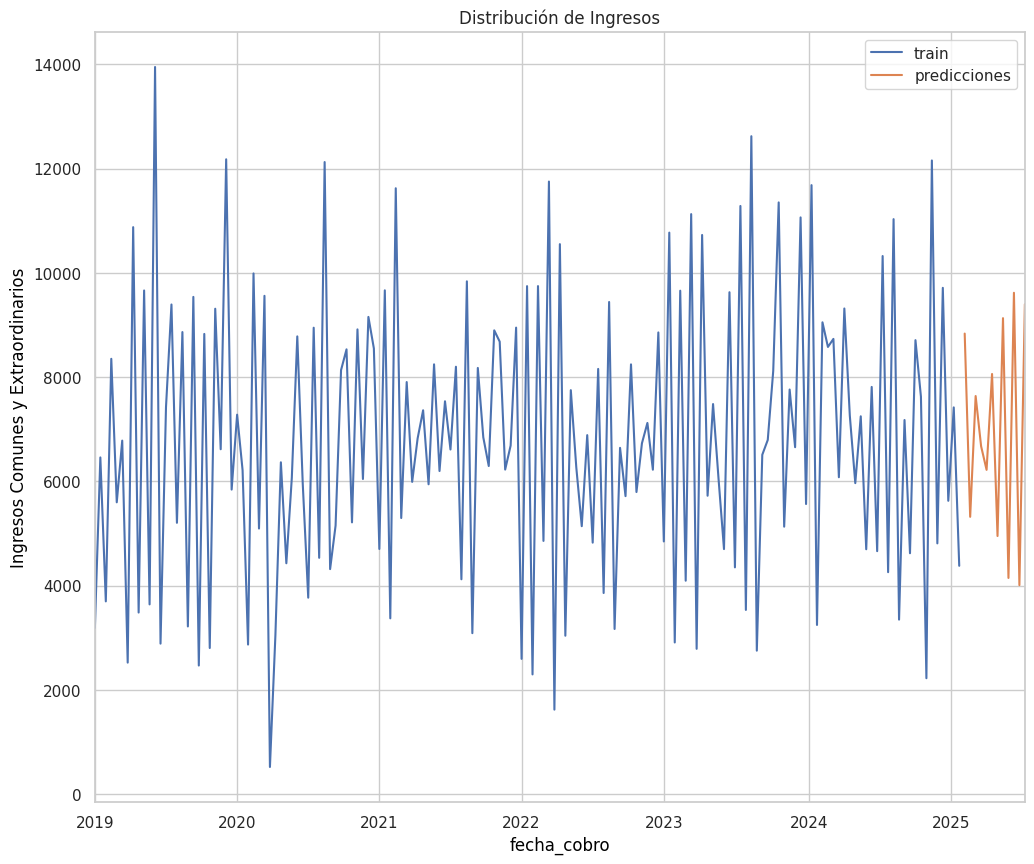

In [ ]:
# Preparación del conjunto de datos
if(tipo_data == 2):
   pd_data1['fecha_pago'] = pd.to_datetime(pd_data1['fecha_pago'])
   y = pd_data1.set_index('fecha_pago')['diferencia']
else:
   pd_data['fecha_cobro'] = pd.to_datetime(pd_data['fecha_cobro'])
   y = pd_data.set_index('fecha_cobro')['diferencia']

y = y.dropna()
y = y.resample(frequency).sum()

y_train = y
y_train.index.freq = frequency

#partición test
print(f"tamaño de muestra de entrenamiento: {len(y_train)}")


if modelo_usar == "forest":
    print("Uso del modelo ForecasterRecursive con RandomForestRegressor")
    # Forecaster recursivo
    forecaster = ForecasterRecursive(regressor = RandomForestRegressor(random_state=123),lags = 6)
    forecaster.fit(y=y_train)
    predicciones = forecaster.predict(steps=steps)
    #las predicciones generadas no contienen fecha, sino un índice numérico, por lo tanto aquí se le asigna una
    predicciones.index = pd.date_range(start=y_train.index[-1], periods=steps, freq=frequency)

if modelo_usar == "svd":
    print("Uso del modelo ForecasterRecursive con LinearRegresion y SVD")
    # Forecaster con regresión lineal y svd
    from sklearn.linear_model import LinearRegression
    from sklearn.decomposition import TruncatedSVD
    lags = 6

    X_train = np.array([y_train.iloc[i:i+lags] for i in range(len(y_train) - lags)])
    y_train_lags = y_train.iloc[lags:]

    # Aplicar SVD para reducir la dimensionalidad
    svd = TruncatedSVD(n_components=2)  # Reducir a 2 componentes
    X_train_svd = svd.fit_transform(X_train)

    # Entrenar un modelo de regresión lineal sobre los componentes de SVD
    model = LinearRegression()
    model.fit(X_train_svd, y_train_lags)

    forecaster = ForecasterRecursive(
                    regressor = model,  # Cambia el modelo aquí
                    lags = lags
                 )
    forecaster.fit(y=y_train)
    predicciones = forecaster.predict(steps=steps)
    predicciones.index = pd.date_range(start=y_train.index[-1], periods=steps, freq=frequency)

if modelo_usar == "sarimax":
    # Uso del modelo Sarimax (arima estacionario)
    try:
       print("Uso del modelo SARIMAX")
       model = Sarimax(order=best_order,seasonal_order=best_seasonal_order)
       results = model.fit(y_train)
       model.summary()
       # Predicción
       predicciones = model.predict(steps=steps)

    except LinAlgError as e:
        print(f"\033[31mError de descomposición LU: {e} (El modelo no ha sido capaz de analizar la data)\033[0m")

if modelo_usar == "arimax":
    #Uso del modelo Arima (arima con regresión)
    print("Uso del modelo ARIMAX")
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(y_train, order=best_order)
    results = model.fit()
    # Predicción
    predicciones = results.predict(start=len(y_train), end=len(y_train) + steps-1)

labels = {0:"Ingresos Consolidados", 1:"Ingresos", 2:"Egresos"}

# Creación del gráfico
fig, ax = plt.subplots(figsize=(12, 10))
plt.title(f"Distribución de {labels[tipo_data]}")
ax.set_ylabel(f'{labels[tipo_data]} Comunes y Extraordinarios', color='black')
ax.set_xlabel('años', color='black')
y_train.plot(ax=ax, label ="train")
predicciones.plot(ax=ax, label='predicciones')
ax.legend()
plt.show()


Ejecución de recomendaciones y comparaciones

<ipython-input-41-9ab391c7b78d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_categorizada['cuenta_contable'] = data_categorizada['cuenta_contable'].apply(categorizar)
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=44, family=2, type=1, proto=6, laddr=('127.0.0.1', 43510), raddr=('127.0.0.1', 35625)>
  self._sock = None
/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=44, family=2, type=1, proto=6, laddr=('127.0.0.1', 33592), raddr=('127.

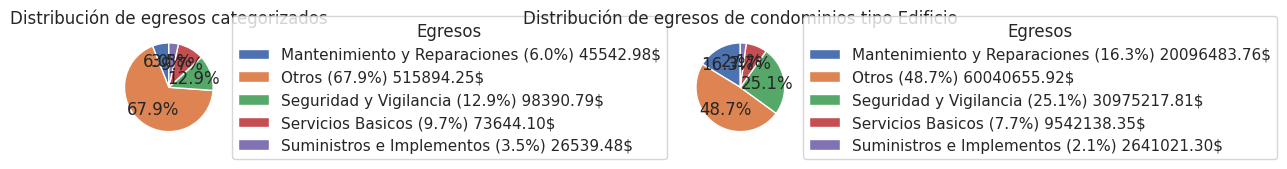

/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=44, family=2, type=1, proto=6, laddr=('127.0.0.1', 46536), raddr=('127.0.0.1', 46033)>
  self._sock = None
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=44, family=2, type=1, proto=6, laddr=('127.0.0.1', 38534), raddr=('127.0.0.1', 34759)>
  self._sock = None
/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/lib/python3.11/socket.py:789: ResourceWarning: unclosed <socket.socket fd=44, family=2, type=1, proto=6, laddr=('127.0.0.1', 57872), radd

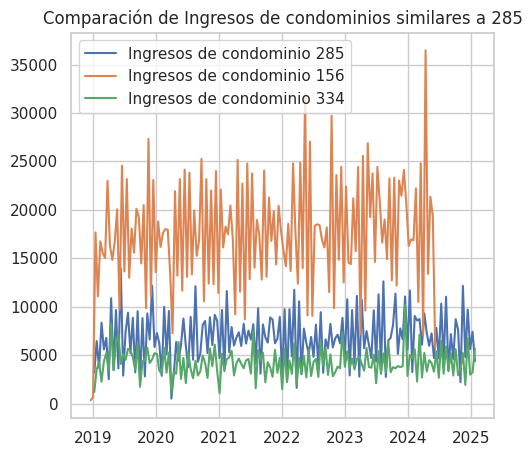

El condominio 285 tiene: 
0 cuentas por cobrar que suman un total de 0.00$ y tarda en promedio 43.18 días en cobrar
ha cobrado 1084217.92$ en total
Tambien tiene: 
0 cuentas por pagar que suman un total de 0.00$ y tarda en promedio 2.43 días en pagar
ha pagado 758612.76$ en total
generando 325605.16$ en total
Se proyectan Ingresos de 83987.32$
porcentaje otros: 0.6787978630852477
**RECOMENDACIONES**
- Los Ingresos Consolidados hasta la fecha manifiestan un superávit, por lo tanto se sugiere crear un fondo de ahorro según la ley de propiedad horizontal o Buscar proyectos o fondos de inversión para utilizar el superávit
- Se sugiere realizar revisiones en los medidores o contratos de los servicios, puesto que los gastos de servicios básicos de este condominio superan la media de gastos de tipos de condominios similares a este
- Se sugiere una auditoría o revisión exhaustiva de los gastos de este condominio puesto que los gastos no identificados (Otros) superan el 50% de los egresos y la 

<ipython-input-41-9ab391c7b78d>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuentas_cobrar['fecha'] = pd.to_datetime(cuentas_cobrar['fecha'])
<ipython-input-41-9ab391c7b78d>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuentas_cobrar['diferencia'] = cuentas_cobrar['valor'].astype(float)-cuentas_cobrar['saldo'].astype(float)
<ipython-input-41-9ab391c7b78d>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [ ]:
def categorizar(description):
    description = description.lower()
    for category, subcategories in mapa_categorizacion_egresos.items():
        if any(map(description.__contains__, subcategories)):
            return category
    return 'Otros'



recomendaciones = []
tipo_condominio = pd_condominio['tipocondominio'].values[0]

#Cálculo de porcentaje de egresos
data_categorizada = pd_data1[['cuenta_contable', 'valor']]
data_categorizada['cuenta_contable'] = data_categorizada['cuenta_contable'].apply(categorizar)
graf=data_categorizada.value_counts()
distribucion_egresos = data_categorizada.set_index('cuenta_contable')['valor'].astype(float)
distribucion_egresos_agrupados = distribucion_egresos.groupby(distribucion_egresos.index).sum()
total_egresos = distribucion_egresos_agrupados.values.sum()
porcentajes = [f'{(v/sum(distribucion_egresos_agrupados))*100:.1f}%' for v in distribucion_egresos_agrupados]
etiquetas_con_porcentajes = [f'{l} ({p}) {v:.2f}$' for l, p, v in zip(distribucion_egresos_agrupados.index, porcentajes, distribucion_egresos_agrupados.values)]

#Cálculo de porcentaje de egresos de todos los condominios del mismo tipo
condominios_mismo_tipo = data_condominios.filter(col("tipocondominio") == tipo_condominio)
ids_condominios_mismo_tipo = condominios_mismo_tipo.select("id_condominio").rdd.flatMap(lambda x: x).collect()
condominios_comparar_egresos = data1.filter(col("id_condominio").isin(ids_condominios_mismo_tipo)).filter(col("valor").rlike("^[+-]?([0-9]*[.])?[0-9]+$")).toPandas()

data_categorizada1 = condominios_comparar_egresos[['cuenta_contable', 'valor']]
data_categorizada1['cuenta_contable'] = data_categorizada1['cuenta_contable'].apply(categorizar)
graf1=data_categorizada1.value_counts()
distribucion_egresos1 = data_categorizada1.set_index('cuenta_contable')['valor'].astype(float)
distribucion_egresos_agrupados1 = distribucion_egresos1.groupby(distribucion_egresos1.index).sum()
total_egresos1 = distribucion_egresos_agrupados1.values.sum()
porcentajes1 = [f'{(v/sum(distribucion_egresos_agrupados1))*100:.1f}%' for v in distribucion_egresos_agrupados1]
etiquetas_con_porcentajes1 = [f'{l} ({p}) {v:.2f}$' for l, p, v in zip(distribucion_egresos_agrupados1.index, porcentajes1, distribucion_egresos_agrupados1.values)]


# Gráfico de pie conjunto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# Gráfico 1
ax1.pie(distribucion_egresos_agrupados.values, autopct='%1.1f%%', startangle=90, shadow=False)
ax1.set_title("Distribución de egresos categorizados")
ax1.legend(etiquetas_con_porcentajes, title="Egresos", loc="center left", bbox_to_anchor=(1, 0.5))
# Gráfico 2
ax2.pie(distribucion_egresos_agrupados1.values, autopct='%1.1f%%', startangle=90, shadow=False)
ax2.set_title(f"Distribución de egresos de condominios tipo {tipo_condominio}")
ax2.legend(etiquetas_con_porcentajes1, title="Egresos", loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Comparación de condominios similares
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for id in id_condominios:
    # ax1 comparación de Ingresos/Egresos de condominios similares (id_condominios)
    pd_data_ingresos = data.filter(col("id_condominio") == id).toPandas()
    pd_data_egresos = data1.filter(col("id_condominio") == id).toPandas()
    pd_data_ingresos['fecha_cobro'] = pd.to_datetime(pd_data_ingresos['fecha_cobro'])
    pd_data_egresos['fecha_pago'] = pd.to_datetime(pd_data_egresos['fecha_pago'])

    pd_condominio = data_condominios.filter(col("id_condominio") == id).toPandas()
    if(tipo_data == 0):
       label = "Ingresos Consolidados"
       pd_data_ingresos['diferencia'] = pd_data_ingresos['valorcobro'].astype(float) - pd_data_egresos['valor_pago'].astype(float)
       dataset = pd_data_ingresos.set_index('fecha_cobro')['diferencia']
    if(tipo_data == 1):
       label = "Ingresos"
       pd_data_ingresos['diferencia'] = pd_data_ingresos['valorcobro'].astype(float)
       dataset = pd_data_ingresos.set_index('fecha_cobro')['diferencia']
    if(tipo_data == 2):
       label = "Egresos"
       pd_data_egresos['diferencia'] = -pd_data_egresos['valor_pago'].astype(float)
       dataset = pd_data_egresos.set_index('fecha_pago')['diferencia']
    dataset = dataset.dropna()
    dataset = dataset.resample(frequency).sum()
    ax1.plot(dataset.index, dataset.values, label=f"{label} de condominio {str(id)}")

    # Solo configurar ax2 si son ingresos
    if tipo_data != 1:
        egresos_categorizados2 = pd_data_egresos[['cuenta_contable', 'valor']]
        egresos_categorizados2['cuenta_contable'] = egresos_categorizados2['cuenta_contable'].apply(categorizar)

        distribucion_egresos2 = egresos_categorizados2.set_index('cuenta_contable')['valor'].astype(float)
        distribucion_egresos_agrupados2 = distribucion_egresos2.groupby(distribucion_egresos2.index).sum()

        # Calcular el monto total y los porcentajes
        monto_total = distribucion_egresos2.sum()
        porcentaje_egresos_agrupados = (distribucion_egresos_agrupados2 / monto_total) * 100

        # Graficar en ax2
        ax2.plot(distribucion_egresos_agrupados2.index, porcentaje_egresos_agrupados, label=f"Condominio {str(id)}")

ax1.set_title(f"Comparación de {label} de condominios similares a {id_condominio}")
ax1.legend()

# Solo configurar ax2 si son ingresos
if tipo_data != 1:
    ax2.set_title("Distribución porcentual de egresos categorizados")
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.legend()
else:
    ax2.set_visible(False)

plt.show()




#diferencia_consolidada = pd_data['valorcobro'].astype(float) - pd_data1['valor_pago'].astype(float)

# Recomendaciones Anticipo
ingresos = pd_data['valorcobro'].astype(float).sum()
anticipos = pd_data['saldo'].astype(float).sum()
porcentaje_anticipos = anticipos / ingresos

if(porcentaje_anticipos > limite_anticipos):
    recomendaciones.append("Se recomienda reducir los anticipos puesto que puede haber problemas de flujo en el futuro")



#Cuentas por pagar y cobrar
cuentas_cobrar = pd_data[pd_data['fecha_cobro'].isnull()]
cuentas_cobrar['fecha'] = pd.to_datetime(cuentas_cobrar['fecha'])
cuentas_cobrar['diferencia'] = cuentas_cobrar['valor'].astype(float)-cuentas_cobrar['saldo'].astype(float)

cuentas_cobrar_dict = cuentas_cobrar.set_index('fecha')['diferencia']
fecha_cobrar_mas_antigua = min(cuentas_cobrar_dict.keys())
total_cobrar = cuentas_cobrar_dict.values.sum()
pd_data['diff_fecha_menos_cobro'] = pd.to_numeric(pd_data['diff_fecha_menos_cobro'], errors='coerce')
media_dias_retraso_cobro = pd_data['diff_fecha_menos_cobro'].mean()

pd_data1['fecha'] = pd.to_datetime(pd_data1['fecha'])

cuentas_pagar = pd_data1[pd_data1['fecha_pago'].isnull()]
cuentas_pagar['fecha'] = pd.to_datetime(cuentas_pagar['fecha'])
cuentas_pagar['diferencia'] = cuentas_pagar['valor'].astype(float)-cuentas_pagar['saldo'].astype(float)
cuentas_pagar = cuentas_pagar[cuentas_pagar['diferencia'] != 0]

cuentas_pagar_dict = cuentas_pagar.set_index('fecha')['diferencia']
total_pagar = cuentas_pagar_dict.values.sum()
pd_data1['diff_fecha_menos_pago'] = pd.to_numeric(pd_data1['diff_fecha_menos_pago'], errors='coerce')
media_dias_retraso_pago = pd_data1['diff_fecha_menos_pago'].mean()


#Recomendaciones Mora
if(len(cuentas_pagar_dict) > 0):
    fecha_pagar_mas_antigua = min(cuentas_pagar_dict.keys())
    fecha_maxima = pd_data1['fecha'].max()
    diferencia_tiempo = fecha_maxima - fecha_pagar_mas_antigua
    # Verificar si la diferencia es mayor a 3 meses (aproximadamente 90 días)
    if diferencia_tiempo > pd.Timedelta(days=90):
        recomendaciones.append(f"Se recomienda emprender acciones judiciales o extrajudiciales puesto que la cuenta por cobrar más antigüa es mayor a 3 meses.")
    else:
        recomendaciones.append(f"Si los ingresos no superan a los egresos se recomienda aplicar una cuota extraordinaria para cubrir el déficit")
total_ingresos = pd_data['valorcobro'].astype(float).sum()
total_egresos = pd_data1['valor_pago'].astype(float).sum()
total_ingresos_consolidados = total_ingresos - total_egresos


print(f"El condominio {id_condominio} tiene: \n{len([val for val in cuentas_cobrar_dict.values if val > 0])} cuentas por cobrar que suman un total de {total_cobrar:.2f}$ y tarda en promedio {media_dias_retraso_cobro:.2f} días en cobrar")
print(f"ha cobrado {total_ingresos:.2f}$ en total")

print(f"Tambien tiene: \n{len([val for val in cuentas_pagar_dict.values if val > 0])} cuentas por pagar que suman un total de {total_pagar:.2f}$ y tarda en promedio {media_dias_retraso_pago:.2f} días en pagar")
print(f"ha pagado {total_egresos:.2f}$ en total")
print(f"generando {total_ingresos_consolidados:.2f}$ en total")

#Recomendaciones Superavit
if(total_ingresos_consolidados > 0):
    recomendaciones.append("Los Ingresos Consolidados hasta la fecha manifiestan un superávit, por lo tanto se sugiere crear un fondo de ahorro según la ley de propiedad horizontal o Buscar proyectos o fondos de inversión para utilizar el superávit")

#Recomendaciones de Predicciones
sumatoria_prediccion = predicciones.values.sum()
if tipo_data == 0: #Consolidado
    total_prediccion = total_ingresos_consolidados + sumatoria_prediccion
    if(total_prediccion > 0):
        recomendaciones.append("Según la proyección realizada se recomienda crear un fondo de ahorro según la ley de propiedad horizontal o buscar proyectos o fondos de inversión para utilizar el superávit")
    else:
        recomendaciones.append(f"Según la proyección realizada se recomienda aplicar una alicuota de aproximadamente {-total_prediccion/steps:.2f}$ durante el periodo de la proyección para corregir el déficit")
        recomendaciones.append(f"Pruebe con un modelo de predicción diferente o analice los datos por separado (Ingresos/Egresos)")
    print(f"Se proyectan Ingresos Consolidados de {sumatoria_prediccion:.2f}$")

if tipo_data == 1: #Ingresos
    total_prediccion = total_ingresos + sumatoria_prediccion
    print(f"Se proyectan Ingresos de {sumatoria_prediccion:.2f}$")

if tipo_data == 2: #Egresos
    total_prediccion = total_ingresos_consolidados + sumatoria_prediccion
    if(total_prediccion < 0):
        recomendaciones.append("Según la proyección realizada puede que sea necesaria una cuota especial para corregir el déficit puesto que se esperan egresos que superan al total de Ingresos Consolidados hasta la fecha")
        recomendaciones.append("Según la proyección realizada puede que sea necesario realizar una auditoría para evaluar la gestión del condominio")
        recomendaciones.append(f"Pruebe con un modelo de predicción diferente o los datos de Ingresos Consolidados para comparar esta proyección")
    if(sumatoria_prediccion > 0):
        recomendaciones.append(f"\033[31mParece que el modelo que seleccionó ({modelo_usar}) no es ideal para esta serie de datos puesto que los egresos no deberían ser mayores a 0, pruebe con un modelo de predicción diferente para comparar esta proyección")
    print(f"Se proyectan Egresos de {sumatoria_prediccion:.2f}$")

#Recomendaciones de mantenimiento
if(distribucion_egresos['Mantenimiento y Reparaciones'].sum()/sum(distribucion_egresos_agrupados) > distribucion_egresos1['Mantenimiento y Reparaciones'].sum()/sum(distribucion_egresos_agrupados1)):
    recomendaciones.append("Se sugiere realizar mantenimiento preventivo e inspecciones a las instalaciones, puesto que los gastos de mantenimiento de este condominio superan la media de gastos de mantenimiento de tipos de condominios similares a este")

#Recomendaciones de servicios básicos
if(distribucion_egresos['Servicios Basicos'].sum()/sum(distribucion_egresos_agrupados) > distribucion_egresos1['Servicios Basicos'].sum()/sum(distribucion_egresos_agrupados1)):
    recomendaciones.append("Se sugiere realizar revisiones en los medidores o contratos de los servicios, puesto que los gastos de servicios básicos de este condominio superan la media de gastos de tipos de condominios similares a este")

#Recomendaciones de Otros
if(distribucion_egresos['Otros'].sum()/sum(distribucion_egresos_agrupados) > .5):
    if(distribucion_egresos['Otros'].sum()/sum(distribucion_egresos_agrupados) > distribucion_egresos1['Otros'].sum()/sum(distribucion_egresos_agrupados1)):
        recomendaciones.append("Se sugiere una auditoría o revisión exhaustiva de los gastos de este condominio puesto que los gastos no identificados (Otros) superan el 50% de los egresos y la media en comparación con condominios similares")
    recomendaciones.append("Se recomienda mejorar el mapa de categorización de egresos para mejorar la clasificación de los mismos")

print(f"porcentaje otros: {distribucion_egresos['Otros'].sum()/sum(distribucion_egresos_agrupados)}")
if(len(recomendaciones) == 0):
    print(f"No hay recomendaciones para este condominio")
else:
    print("\033[96m**RECOMENDACIONES**")
    for recomendacion in recomendaciones:
        print(f'\033[96m- {recomendacion}')


2025-02-20 22:17:08.760498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 22:17:08.942785: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 22:17:09.101217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740104229.240065  384279 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740104229.281224  384279 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1740104233.105382  384279 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/home/rtainor/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(self._numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


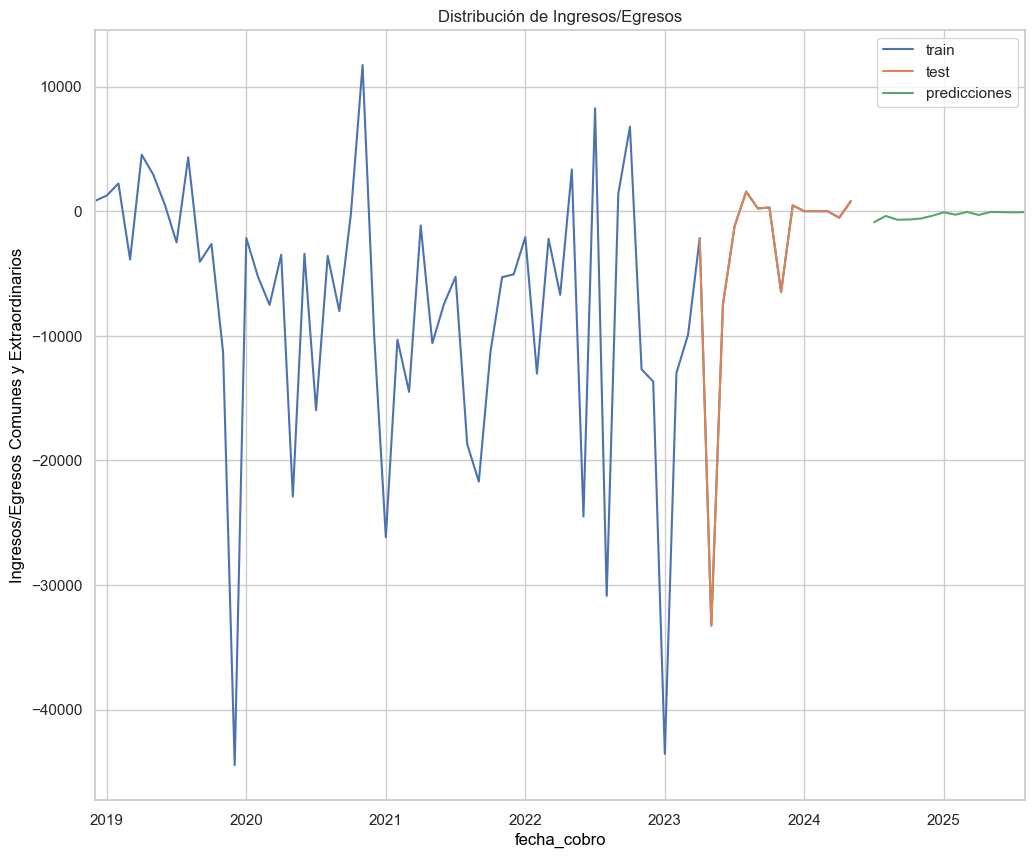

 tamaño de muestra de prueba: 14, tamaño de predicciones: 14
[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[np.float32(14.946187), np.float32(6.442929), np.float32(11.529608), np.float32(11.304417), np.float32(9.959921), np.float32(6.2315817), np.float32(1.4800442), np.float32(4.7322717), np.float32(1.0), np.float32(5.113163), np.float32(1.1098422), np.float32(1.2282704), np.float32(1.6144909), np.float32(1.1814005)]
el umbral de error de la curva roc es de 1047.2537954545455


/tmp/ipykernel_384279/683965040.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clasificacion = [1 if abs(y_test[i]-predicciones.values[i]) < umbral else 0 for i in range(len(y_test))]


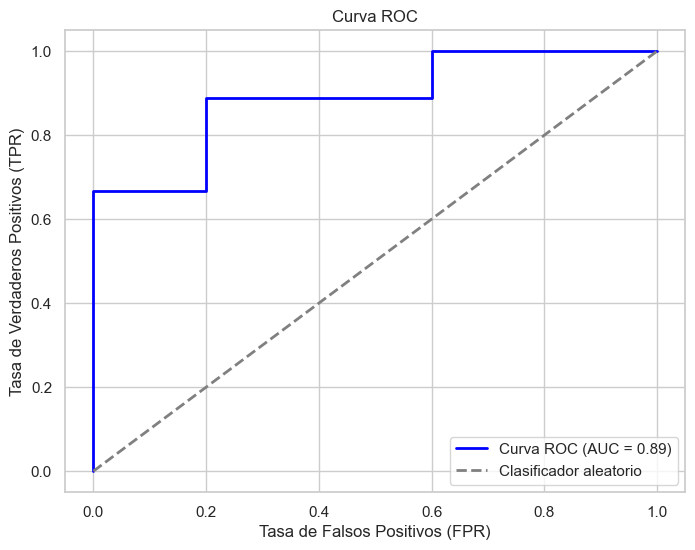

Error de test (mse): 83869141.59962015
Error de test (mae): 3792.438927448817
Coeficiente de determinación (R²): -0.11688888950579712
Área debajo de la curva ROC (ROC AUC): 0.8888888888888888


{'mse': 83869141.59962015,
 'mae': 83869141.59962015,
 'r2': -0.11688888950579712,
 'auc': np.float64(0.8888888888888888)}

In [ ]:
# Esta sería la implementación usando un modelo de redes neuronales, sin embargo este presenta el inconveniente
# de que cada vez que se entrena, la respuesta será distinta, para evitar la creación de un sistema de guardado/carga del modelo
# se sugiere obviarlo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Preparar los datos para LSTM
def create_dataset(series, lags):
    X, y = [], []
    for i in range(len(series) - lags):
        X.append(series.iloc[i:i+lags])
        y.append(series.iloc[i+lags])
    return np.array(X), np.array(y)

lags = 6  # Número de lags
X_train, y_train_lags = create_dataset(y_train, lags)

# Redimensionar los datos para LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lags, 1), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)))  # Capa LSTM con 50 neuronas
model.add(Dense(1))  # Capa de salida
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train_lags, epochs=200, verbose=0)

# Predicción
last_window = y_train.iloc[-lags:].values.reshape(1, lags, 1)  # Últimos 'lags' valores
predicciones = []
steps = len(y_test)
for i in range(steps):
    pred = model.predict(last_window)
    predicciones.append(pred[0][0])
    pred = pred.reshape(1, 1, 1)  # Forma: (1, 1, 1)

    # Actualizar last_window
    last_window = np.append(last_window[:, 1:, :], pred, axis=1)
    #last_window = np.append(last_window[:, 1:, :], [[pred]], axis=1)

# Asignar fechas a las predicciones
predicciones = pd.Series(predicciones, index=pd.date_range(start=y_train.index[-1] + pd.DateOffset(months=1), periods=steps, freq='MS'))


mostrar_distribucion(y_train, y_test, predicciones[:steps])